In [1]:
################################################################################################
# 
#       2020.1.8
#       -----------
#       siameseNet 网络test
#       1. 图像增强 https://blog.csdn.net/weixin_40793406/article/details/84867143
#       https://www.pytorchtutorial.com/pytorch-one-shot-learning/#Contrastive_Loss_function
# 
################################################################################################

import sys
sys.path.append('..')

import PIL
from PIL import Image

from torchvision import transforms as tfs
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os


image_width = 200
image_height = 200

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # 输入为 100 x 100
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            # 对每个 channel 按照概率设置为 0
            nn.Dropout2d(p=.2),
            # 输出为 4 * 100 * 100
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            # 输出为 8 * 100 * 100

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            # 输出为 8 * 100 * 100
        )

        self.fc1 = nn.Sequential(
            # nn.Linear(8*100*100, 500),
            nn.Linear(8*image_width*image_height, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [3]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        # self.margin = torch.from_numpy(margin)
        self.margin = torch.tensor([margin])

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        # temp = self.margin - euclidean_distance
        # loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2)
        #                             (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        loss_contrastive = ((1 - label) * torch.pow(euclidean_distance, 2)
                        + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        return loss_contrastive

class SiameseNetworkDataset():
    __set_size__ = 90
    __batch_size__ = 10

    def __init__(self,set_size=90,batch_size=10,transform=None,should_invert=False):
        self.imageFolderDataset = []
        self.train_dataloader = []

        self.__set_size__ = set_size
        self.__batch_size__ = batch_size

        self.transform = tfs.Compose([
                            tfs.Resize((image_width,image_height)),
                            # tfs.RandomHorizontalFlip(),
                            # tfs.RandomCrop(128),
                            tfs.ToTensor()
                        ])
        self.should_invert = should_invert
        
    def __getitem__(self, class_num=40):
        '''
        如果图像来自同一个类，标签将为0，否则为1
        TODO: 由于classed_pack 每类可能有2-3张, 此时参数item_num无效,故删去参数中的item_num
        '''
        data0 = torch.empty(0, 3, image_width, image_height)
        data1 = torch.empty(0, 3, image_width, image_height)

        should_get_same_class = random.randint(0,1)
        for i in range(self.__batch_size__):
            img0_class = random.randint(0,class_num-1)
            #we need to make sure approx 50% of images are in the same class
            
            if should_get_same_class:
                item_num = len(self.imageFolderDataset[img0_class])
                temp = random.sample(list(range(0,item_num)), 2)
                img0_tuple = (self.imageFolderDataset[img0_class][temp[0]], img0_class)
                img1_tuple = (self.imageFolderDataset[img0_class][temp[1]], img0_class)
            else:
                img1_class = random.randint(0, class_num - 1)
                # 保证属于不同类别
                while img1_class == img0_class:
                    img1_class = random.randint(0, class_num - 1)
                item_num = len(self.imageFolderDataset[img0_class])
                img0_tuple = (self.imageFolderDataset[img0_class][random.randint(0, item_num - 1)], img0_class)
                item_num = len(self.imageFolderDataset[img1_class])
                img1_tuple = (self.imageFolderDataset[img1_class][random.randint(0, item_num - 1)], img1_class)

            img0 = Image.open(img0_tuple[0])
            img1 = Image.open(img1_tuple[0])
            # 用以指定一种色彩模式, "L"8位像素，黑白
            # img0 = img0.convert("L")
            # img1 = img1.convert("L")

            # img0 = img0.resize((100,100),Image.BILINEAR)
            # img1 = img1.resize((100,100),Image.BILINEAR)

            if self.should_invert:
                # 二值图像黑白反转,默认不采用
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)
            
            img0 = torch.unsqueeze(img0, dim=0).float()
            img1 = torch.unsqueeze(img1, dim=0).float()

            data0 = torch.cat((data0, img0), dim=0)
            data1 = torch.cat((data1, img1), dim=0)

        # return data0, data1, should_get_same_class ^ 1
        return data0, data1, torch.from_numpy(np.array([should_get_same_class ^ 1], dtype=np.float32))

    def att_face_data(self):
        ''' AT&T 数据集: 共40类, 每类十张图像 '''
        local = 'D:/MINE_FILE/dataSet/att_faces/'
        self.imageFolderDataset = []
        for i in range(1, 40 + 1):
            temp = []
            sub_floder = local + 's' + str(i) + '/'
            for j in range(1, 10 + 1):
                temp.append(sub_floder + str(j) + '.pgm')
            self.imageFolderDataset.append(temp)
        # 为数据集添加数据
        for i in range(self.__set_size__):
            img0, img1, label = self.__getitem__()
            self.train_dataloader.append((img0, img1, label))
            # print("\r" + 'Cnt: ' + str(i)  + '/' + str(self.__epoch_size__) + '[' +">>" * i + ']',end=' ')

    def classed_pack(self):
        local = 'image/classed_pack/2019-03-14 22-19-img/'
        local1 = 'image/classed_pack/2019-03-14 16-30-img/'
        self.imageFolderDataset = []

        # floader1
        subFloader = os.listdir(local)
        for i in subFloader:
            temp = []
            sub_dir = local + i + '/'
            subsubFloader = os.listdir(sub_dir)
            for j in subsubFloader:
                temp.append(sub_dir + j)
            self.imageFolderDataset.append(temp)
        # floader2
        subFloader = os.listdir(local1)
        for i in subFloader:
            temp = []
            sub_dir = local + i + '/'
            subsubFloader = os.listdir(sub_dir)
            for j in subsubFloader:
                temp.append(sub_dir + j)
            self.imageFolderDataset.append(temp)

        # 为数据集添加数据
        for i in range(self.__set_size__):
            img0, img1, label = self.__getitem__(len(self.imageFolderDataset))
            self.train_dataloader.append((img0, img1, label))

In [10]:
def show_plot(x, y):
    plt.plot(x, y)
    plt.show()

if __name__ == '__main__':
    batch_size = 1 
    data_num = 600      # 训练集总数
    train_number_epochs = 20

    # net = SiameseNetwork().cuda()
    print('start preparing the data...')
    train_data = SiameseNetworkDataset(set_size=data_num, batch_size=batch_size)
    # train_data.att_face_data()
    train_data.classed_pack()
    print('finish preparing the data...')

    net = SiameseNetwork()
    print(net)
    
    # 加载模型
    net.load_state_dict(torch.load('net031401_params.pkl'))
    net.eval()
    
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
    
    counter = []
    loss_history = [[],[]]
    iteration_number= 1     # 实验数据记录的步长

    for epoch in range(0, train_number_epochs):
        # 使用80%训练
        ind_test = int(len(train_data.train_dataloader) * 0.8)
        
        # train
        for i, data in enumerate(train_data.train_dataloader[0:ind_test]):
            img0, img1, label = data
            # img0 = im_aug1(img0)
            # img1 = im_aug1(img1)

            # img0 = torch.unsqueeze(img0, dim=0).float()
            # img1 = torch.unsqueeze(img1, dim=0).float()
            # img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
            output1,output2 = net(img0,img1)
            optimizer.zero_grad()
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            
            euclidean_distance = F.pairwise_distance(output1, output2)
            # loss_contrastive.backward(torch.tensor([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))
            optimizer.step()
            if i % iteration_number == 0:
                label = int(label)
                print("Epoch {}: step {}, label {}, loss {:.4f} ".format(epoch, i, label, loss_contrastive.data[0]),end='')
                print(', e_dis {:.6f}'.format(euclidean_distance.cpu().data.numpy()[0]))
                # 为后续图形化训练过程总结准备
                counter.append(iteration_number)
                loss_history[label].append(loss_contrastive.data[0])
        
        # test
        val_loss = [0.0, 0.0]
        num_test = [1, 1]
        e_dis = [0.0, 0.0]
        for i, data in enumerate(train_data.train_dataloader[ind_test:],start=1):
            img0, img1, label = data
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            
            euclidean_distance = F.pairwise_distance(output1, output2)
            
            label = int(label)
            e_dis[label] += euclidean_distance.cpu().data.numpy()[0]
            val_loss[label] += loss_contrastive.data[0]
            num_test[label] += 1
        
        print("Epoch Test {}: label0 {}->{:.4f}, label1 {}->{:.4f}, ".format(epoch, num_test[0] - 1, val_loss[0] / num_test[0], num_test[1] - 1, val_loss[1] / num_test[1]), end='')
        print("\t dis0 {:.4f}, dis1 {:.4f}".format(e_dis[0]/num_test[0], e_dis[1]/num_test[1]))
        
    # show_plot(counter, loss_history)

start preparing the data...
finish preparing the data...
SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=320000, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_feat

Epoch 0: step 125, label 1, loss 0.8981 , e_dis 0.659800
Epoch 0: step 126, label 0, loss 0.0385 , e_dis 0.277480
Epoch 0: step 127, label 1, loss 0.4129 , e_dis 1.091314
Epoch 0: step 128, label 1, loss 0.8266 , e_dis 0.714233
Epoch 0: step 129, label 0, loss 0.2679 , e_dis 0.731951
Epoch 0: step 130, label 0, loss 0.1517 , e_dis 0.550773
Epoch 0: step 131, label 1, loss 0.6108 , e_dis 0.894740
Epoch 0: step 132, label 1, loss 1.4982 , e_dis 0.268976
Epoch 0: step 133, label 1, loss 0.5111 , e_dis 0.988978
Epoch 0: step 134, label 0, loss 0.0959 , e_dis 0.437929
Epoch 0: step 135, label 1, loss 0.1908 , e_dis 1.382247
Epoch 0: step 136, label 1, loss 1.7218 , e_dis 0.144316
Epoch 0: step 137, label 0, loss 0.1858 , e_dis 0.609526
Epoch 0: step 138, label 1, loss 0.0000 , e_dis 2.283729
Epoch 0: step 139, label 1, loss 1.4066 , e_dis 0.322718
Epoch 0: step 140, label 1, loss 0.6933 , e_dis 0.822425
Epoch 0: step 141, label 0, loss 0.8643 , e_dis 1.314768
Epoch 0: step 142, label 0, los

Epoch 0: step 268, label 0, loss 0.0027 , e_dis 0.073464
Epoch 0: step 269, label 0, loss 0.1771 , e_dis 0.595113
Epoch 0: step 270, label 1, loss 1.1320 , e_dis 0.495310
Epoch 0: step 271, label 0, loss 0.0925 , e_dis 0.430133
Epoch 0: step 272, label 0, loss 0.7969 , e_dis 1.262464
Epoch 0: step 273, label 0, loss 0.0607 , e_dis 0.348401
Epoch 0: step 274, label 1, loss 0.0000 , e_dis 3.078387
Epoch 0: step 275, label 1, loss 0.0139 , e_dis 1.833122
Epoch 0: step 276, label 1, loss 1.0613 , e_dis 0.543082
Epoch 0: step 277, label 0, loss 0.0617 , e_dis 0.351142
Epoch 0: step 278, label 0, loss 0.2725 , e_dis 0.738287
Epoch 0: step 279, label 1, loss 0.2855 , e_dis 1.244292
Epoch 0: step 280, label 0, loss 0.1283 , e_dis 0.506578
Epoch 0: step 281, label 0, loss 0.1826 , e_dis 0.604288
Epoch 0: step 282, label 1, loss 1.5138 , e_dis 0.260024
Epoch 0: step 283, label 0, loss 0.2060 , e_dis 0.641913
Epoch 0: step 284, label 1, loss 1.2293 , e_dis 0.432016
Epoch 0: step 285, label 1, los

Epoch 0: step 411, label 1, loss 0.3156 , e_dis 1.205496
Epoch 0: step 412, label 0, loss 0.1668 , e_dis 0.577611
Epoch 0: step 413, label 1, loss 0.0230 , e_dis 1.785422
Epoch 0: step 414, label 0, loss 0.2717 , e_dis 0.737207
Epoch 0: step 415, label 0, loss 2.0106 , e_dis 2.005278
Epoch 0: step 416, label 1, loss 0.0000 , e_dis 2.063540
Epoch 0: step 417, label 1, loss 0.5663 , e_dis 0.935756
Epoch 0: step 418, label 0, loss 0.6916 , e_dis 1.176097
Epoch 0: step 419, label 0, loss 1.0819 , e_dis 1.471008
Epoch 0: step 420, label 1, loss 0.0000 , e_dis 3.015095
Epoch 0: step 421, label 1, loss 0.0000 , e_dis 2.981644
Epoch 0: step 422, label 1, loss 0.2855 , e_dis 1.244407
Epoch 0: step 423, label 1, loss 0.0414 , e_dis 1.712278
Epoch 0: step 424, label 1, loss 0.0000 , e_dis 2.644604
Epoch 0: step 425, label 0, loss 1.3678 , e_dis 1.653940
Epoch 0: step 426, label 1, loss 1.1524 , e_dis 0.481835
Epoch 0: step 427, label 1, loss 1.2761 , e_dis 0.402450
Epoch 0: step 428, label 1, los

Epoch 1: step 74, label 0, loss 0.0749 , e_dis 0.387029
Epoch 1: step 75, label 0, loss 0.1864 , e_dis 0.610573
Epoch 1: step 76, label 1, loss 0.4278 , e_dis 1.074996
Epoch 1: step 77, label 0, loss 0.0299 , e_dis 0.244707
Epoch 1: step 78, label 1, loss 1.4225 , e_dis 0.313258
Epoch 1: step 79, label 0, loss 0.0393 , e_dis 0.280534
Epoch 1: step 80, label 1, loss 0.0000 , e_dis 2.588171
Epoch 1: step 81, label 1, loss 0.0000 , e_dis 3.391273
Epoch 1: step 82, label 1, loss 0.2536 , e_dis 1.287753
Epoch 1: step 83, label 0, loss 0.0190 , e_dis 0.194806
Epoch 1: step 84, label 1, loss 0.8126 , e_dis 0.725146
Epoch 1: step 85, label 0, loss 0.0196 , e_dis 0.197941
Epoch 1: step 86, label 0, loss 0.0302 , e_dis 0.245900
Epoch 1: step 87, label 1, loss 0.4614 , e_dis 1.039410
Epoch 1: step 88, label 1, loss 0.0000 , e_dis 4.286510
Epoch 1: step 89, label 1, loss 0.7174 , e_dis 0.802131
Epoch 1: step 90, label 0, loss 0.0048 , e_dis 0.097654
Epoch 1: step 91, label 0, loss 0.5838 , e_dis 1

Epoch 1: step 218, label 1, loss 1.5135 , e_dis 0.260154
Epoch 1: step 219, label 0, loss 0.0881 , e_dis 0.419815
Epoch 1: step 220, label 0, loss 0.1841 , e_dis 0.606812
Epoch 1: step 221, label 1, loss 0.4403 , e_dis 1.061624
Epoch 1: step 222, label 1, loss 0.0000 , e_dis 3.422790
Epoch 1: step 223, label 0, loss 0.1114 , e_dis 0.471930
Epoch 1: step 224, label 0, loss 0.0357 , e_dis 0.267187
Epoch 1: step 225, label 0, loss 0.7355 , e_dis 1.212829
Epoch 1: step 226, label 0, loss 0.0287 , e_dis 0.239437
Epoch 1: step 227, label 1, loss 0.0000 , e_dis 4.018734
Epoch 1: step 228, label 0, loss 0.2645 , e_dis 0.727345
Epoch 1: step 229, label 1, loss 0.0000 , e_dis 2.485034
Epoch 1: step 230, label 1, loss 0.8867 , e_dis 0.668277
Epoch 1: step 231, label 0, loss 0.2527 , e_dis 0.710886
Epoch 1: step 232, label 1, loss 0.0000 , e_dis 2.168131
Epoch 1: step 233, label 1, loss 1.3969 , e_dis 0.328532
Epoch 1: step 234, label 1, loss 0.7671 , e_dis 0.761396
Epoch 1: step 235, label 1, los

Epoch 1: step 361, label 1, loss 0.0000 , e_dis 2.024895
Epoch 1: step 362, label 1, loss 0.4386 , e_dis 1.063433
Epoch 1: step 363, label 1, loss 0.0000 , e_dis 2.306652
Epoch 1: step 364, label 0, loss 0.2162 , e_dis 0.657524
Epoch 1: step 365, label 0, loss 0.0124 , e_dis 0.157497
Epoch 1: step 366, label 1, loss 0.9654 , e_dis 0.610458
Epoch 1: step 367, label 1, loss 0.0953 , e_dis 1.563493
Epoch 1: step 368, label 1, loss 0.0759 , e_dis 1.610267
Epoch 1: step 369, label 1, loss 0.0000 , e_dis 3.051521
Epoch 1: step 370, label 0, loss 0.2849 , e_dis 0.754873
Epoch 1: step 371, label 0, loss 0.3658 , e_dis 0.855374
Epoch 1: step 372, label 1, loss 0.0000 , e_dis 2.571143
Epoch 1: step 373, label 0, loss 1.0328 , e_dis 1.437216
Epoch 1: step 374, label 0, loss 0.0376 , e_dis 0.274382
Epoch 1: step 375, label 1, loss 0.8949 , e_dis 0.662196
Epoch 1: step 376, label 0, loss 2.3001 , e_dis 2.144815
Epoch 1: step 377, label 0, loss 0.1150 , e_dis 0.479588
Epoch 1: step 378, label 1, los

Epoch 2: step 23, label 0, loss 0.2112 , e_dis 0.649948
Epoch 2: step 24, label 0, loss 0.0108 , e_dis 0.147256
Epoch 2: step 25, label 0, loss 0.0342 , e_dis 0.261362
Epoch 2: step 26, label 0, loss 1.3113 , e_dis 1.619444
Epoch 2: step 27, label 1, loss 0.0000 , e_dis 2.145273
Epoch 2: step 28, label 1, loss 0.0000 , e_dis 2.386686
Epoch 2: step 29, label 0, loss 0.0780 , e_dis 0.394936
Epoch 2: step 30, label 1, loss 0.0216 , e_dis 1.792020
Epoch 2: step 31, label 1, loss 1.2104 , e_dis 0.444122
Epoch 2: step 32, label 1, loss 0.0057 , e_dis 1.893679
Epoch 2: step 33, label 0, loss 0.2668 , e_dis 0.730520
Epoch 2: step 34, label 1, loss 0.0000 , e_dis 2.327067
Epoch 2: step 35, label 0, loss 0.0590 , e_dis 0.343429
Epoch 2: step 36, label 1, loss 0.0000 , e_dis 2.523178
Epoch 2: step 37, label 0, loss 0.0949 , e_dis 0.435625
Epoch 2: step 38, label 1, loss 0.0000 , e_dis 4.299429
Epoch 2: step 39, label 1, loss 0.4466 , e_dis 1.054864
Epoch 2: step 40, label 1, loss 0.5192 , e_dis 0

Epoch 2: step 168, label 1, loss 0.0000 , e_dis 2.445925
Epoch 2: step 169, label 0, loss 0.0665 , e_dis 0.364665
Epoch 2: step 170, label 1, loss 0.0000 , e_dis 3.328720
Epoch 2: step 171, label 0, loss 0.0022 , e_dis 0.066019
Epoch 2: step 172, label 0, loss 0.1752 , e_dis 0.591882
Epoch 2: step 173, label 0, loss 0.2311 , e_dis 0.679876
Epoch 2: step 174, label 0, loss 0.0207 , e_dis 0.203387
Epoch 2: step 175, label 1, loss 0.3367 , e_dis 1.179331
Epoch 2: step 176, label 1, loss 1.0606 , e_dis 0.543553
Epoch 2: step 177, label 1, loss 0.0000 , e_dis 4.750028
Epoch 2: step 178, label 1, loss 0.1185 , e_dis 1.513209
Epoch 2: step 179, label 1, loss 1.6869 , e_dis 0.163200
Epoch 2: step 180, label 1, loss 0.7194 , e_dis 0.800502
Epoch 2: step 181, label 0, loss 0.2115 , e_dis 0.650328
Epoch 2: step 182, label 0, loss 0.0376 , e_dis 0.274135
Epoch 2: step 183, label 1, loss 0.0000 , e_dis 2.598171
Epoch 2: step 184, label 0, loss 0.4357 , e_dis 0.933457
Epoch 2: step 185, label 1, los

Epoch 2: step 311, label 1, loss 0.9531 , e_dis 0.619338
Epoch 2: step 312, label 1, loss 0.0515 , e_dis 1.679025
Epoch 2: step 313, label 1, loss 0.0000 , e_dis 3.089400
Epoch 2: step 314, label 1, loss 0.0000 , e_dis 2.472009
Epoch 2: step 315, label 1, loss 0.0000 , e_dis 3.015422
Epoch 2: step 316, label 1, loss 0.0038 , e_dis 1.912415
Epoch 2: step 317, label 0, loss 0.3771 , e_dis 0.868486
Epoch 2: step 318, label 0, loss 0.0049 , e_dis 0.098783
Epoch 2: step 319, label 0, loss 0.0818 , e_dis 0.404470
Epoch 2: step 320, label 0, loss 0.0823 , e_dis 0.405634
Epoch 2: step 321, label 1, loss 0.0000 , e_dis 2.334526
Epoch 2: step 322, label 0, loss 0.0103 , e_dis 0.143776
Epoch 2: step 323, label 1, loss 0.0003 , e_dis 1.976075
Epoch 2: step 324, label 1, loss 0.1591 , e_dis 1.435974
Epoch 2: step 325, label 0, loss 0.4726 , e_dis 0.972253
Epoch 2: step 326, label 0, loss 0.2142 , e_dis 0.654557
Epoch 2: step 327, label 0, loss 0.0040 , e_dis 0.089332
Epoch 2: step 328, label 1, los

Epoch 2: step 454, label 0, loss 0.6290 , e_dis 1.121565
Epoch 2: step 455, label 0, loss 0.8443 , e_dis 1.299465
Epoch 2: step 456, label 1, loss 0.0000 , e_dis 2.373508
Epoch 2: step 457, label 1, loss 0.1329 , e_dis 1.484525
Epoch 2: step 458, label 1, loss 0.2516 , e_dis 1.290683
Epoch 2: step 459, label 0, loss 0.0484 , e_dis 0.311212
Epoch 2: step 460, label 0, loss 0.0203 , e_dis 0.201471
Epoch 2: step 461, label 0, loss 0.0192 , e_dis 0.195859
Epoch 2: step 462, label 1, loss 0.7589 , e_dis 0.768024
Epoch 2: step 463, label 0, loss 0.0669 , e_dis 0.365727
Epoch 2: step 464, label 1, loss 0.3344 , e_dis 1.182203
Epoch 2: step 465, label 1, loss 1.3092 , e_dis 0.381849
Epoch 2: step 466, label 1, loss 0.0329 , e_dis 1.743326
Epoch 2: step 467, label 1, loss 0.0000 , e_dis 3.040001
Epoch 2: step 468, label 0, loss 0.0284 , e_dis 0.238358
Epoch 2: step 469, label 0, loss 0.0459 , e_dis 0.303134
Epoch 2: step 470, label 1, loss 0.0000 , e_dis 3.153828
Epoch 2: step 471, label 1, los

Epoch 3: step 118, label 1, loss 0.0000 , e_dis 2.378481
Epoch 3: step 119, label 0, loss 0.2340 , e_dis 0.684056
Epoch 3: step 120, label 1, loss 0.0000 , e_dis 3.087425
Epoch 3: step 121, label 0, loss 0.1239 , e_dis 0.497788
Epoch 3: step 122, label 0, loss 0.2966 , e_dis 0.770198
Epoch 3: step 123, label 0, loss 0.0177 , e_dis 0.188110
Epoch 3: step 124, label 0, loss 0.0824 , e_dis 0.405991
Epoch 3: step 125, label 1, loss 0.9843 , e_dis 0.596958
Epoch 3: step 126, label 0, loss 0.0049 , e_dis 0.098970
Epoch 3: step 127, label 1, loss 0.4858 , e_dis 1.014350
Epoch 3: step 128, label 1, loss 0.5088 , e_dis 0.991239
Epoch 3: step 129, label 0, loss 0.1899 , e_dis 0.616346
Epoch 3: step 130, label 0, loss 0.0693 , e_dis 0.372394
Epoch 3: step 131, label 1, loss 0.0000 , e_dis 2.572889
Epoch 3: step 132, label 1, loss 0.0000 , e_dis 3.420688
Epoch 3: step 133, label 1, loss 0.0000 , e_dis 3.437850
Epoch 3: step 134, label 0, loss 0.0253 , e_dis 0.225095
Epoch 3: step 135, label 1, los

Epoch 3: step 261, label 0, loss 0.0056 , e_dis 0.105912
Epoch 3: step 262, label 1, loss 0.0000 , e_dis 3.892586
Epoch 3: step 263, label 0, loss 0.0261 , e_dis 0.228317
Epoch 3: step 264, label 0, loss 0.0039 , e_dis 0.088447
Epoch 3: step 265, label 1, loss 0.0000 , e_dis 2.420989
Epoch 3: step 266, label 0, loss 0.0118 , e_dis 0.153601
Epoch 3: step 267, label 1, loss 0.0000 , e_dis 3.279274
Epoch 3: step 268, label 0, loss 0.0059 , e_dis 0.109068
Epoch 3: step 269, label 0, loss 0.0268 , e_dis 0.231722
Epoch 3: step 270, label 1, loss 0.2262 , e_dis 1.327354
Epoch 3: step 271, label 0, loss 1.0957 , e_dis 1.480358
Epoch 3: step 272, label 0, loss 1.8405 , e_dis 1.918611
Epoch 3: step 273, label 0, loss 0.0333 , e_dis 0.258131
Epoch 3: step 274, label 1, loss 0.0000 , e_dis 2.257431
Epoch 3: step 275, label 1, loss 0.0000 , e_dis 2.608429
Epoch 3: step 276, label 1, loss 0.0000 , e_dis 2.011715
Epoch 3: step 277, label 0, loss 0.0379 , e_dis 0.275349
Epoch 3: step 278, label 0, los

Epoch 3: step 404, label 1, loss 0.0000 , e_dis 2.097610
Epoch 3: step 405, label 0, loss 0.0590 , e_dis 0.343539
Epoch 3: step 406, label 0, loss 0.0248 , e_dis 0.222494
Epoch 3: step 407, label 1, loss 0.0784 , e_dis 1.604049
Epoch 3: step 408, label 1, loss 0.2982 , e_dis 1.227699
Epoch 3: step 409, label 0, loss 0.0884 , e_dis 0.420459
Epoch 3: step 410, label 1, loss 0.2495 , e_dis 1.293547
Epoch 3: step 411, label 1, loss 0.3635 , e_dis 1.147319
Epoch 3: step 412, label 0, loss 0.0736 , e_dis 0.383716
Epoch 3: step 413, label 1, loss 0.0000 , e_dis 2.608481
Epoch 3: step 414, label 0, loss 0.0610 , e_dis 0.349363
Epoch 3: step 415, label 0, loss 0.0656 , e_dis 0.362171
Epoch 3: step 416, label 1, loss 0.1432 , e_dis 1.464751
Epoch 3: step 417, label 1, loss 0.5294 , e_dis 0.970999
Epoch 3: step 418, label 0, loss 0.6464 , e_dis 1.137010
Epoch 3: step 419, label 0, loss 0.0047 , e_dis 0.097005
Epoch 3: step 420, label 1, loss 0.0000 , e_dis 4.851482
Epoch 3: step 421, label 1, los

Epoch 4: step 67, label 1, loss 0.1530 , e_dis 1.446792
Epoch 4: step 68, label 0, loss 0.4150 , e_dis 0.911056
Epoch 4: step 69, label 1, loss 0.0000 , e_dis 2.492983
Epoch 4: step 70, label 0, loss 0.0122 , e_dis 0.156032
Epoch 4: step 71, label 1, loss 0.0000 , e_dis 3.212397
Epoch 4: step 72, label 1, loss 0.1766 , e_dis 1.405620
Epoch 4: step 73, label 1, loss 0.0000 , e_dis 3.137366
Epoch 4: step 74, label 0, loss 0.0116 , e_dis 0.151995
Epoch 4: step 75, label 0, loss 0.0752 , e_dis 0.387928
Epoch 4: step 76, label 1, loss 0.0000 , e_dis 2.079802
Epoch 4: step 77, label 0, loss 0.5769 , e_dis 1.074131
Epoch 4: step 78, label 1, loss 0.0000 , e_dis 2.005198
Epoch 4: step 79, label 0, loss 0.1475 , e_dis 0.543229
Epoch 4: step 80, label 1, loss 0.0000 , e_dis 4.442051
Epoch 4: step 81, label 1, loss 0.0000 , e_dis 4.801199
Epoch 4: step 82, label 1, loss 0.0037 , e_dis 1.914430
Epoch 4: step 83, label 0, loss 0.0344 , e_dis 0.262253
Epoch 4: step 84, label 1, loss 0.0000 , e_dis 2

Epoch 4: step 211, label 0, loss 0.0647 , e_dis 0.359845
Epoch 4: step 212, label 0, loss 0.0143 , e_dis 0.169021
Epoch 4: step 213, label 0, loss 0.3537 , e_dis 0.841106
Epoch 4: step 214, label 0, loss 0.1223 , e_dis 0.494646
Epoch 4: step 215, label 0, loss 0.0002 , e_dis 0.022096
Epoch 4: step 216, label 1, loss 0.0000 , e_dis 2.003018
Epoch 4: step 217, label 0, loss 0.1169 , e_dis 0.483519
Epoch 4: step 218, label 1, loss 0.2123 , e_dis 1.348455
Epoch 4: step 219, label 0, loss 0.0052 , e_dis 0.102173
Epoch 4: step 220, label 0, loss 0.2105 , e_dis 0.648835
Epoch 4: step 221, label 1, loss 0.0375 , e_dis 1.726115
Epoch 4: step 222, label 1, loss 0.0000 , e_dis 2.952698
Epoch 4: step 223, label 0, loss 0.3707 , e_dis 0.861032
Epoch 4: step 224, label 0, loss 0.0733 , e_dis 0.382939
Epoch 4: step 225, label 0, loss 0.2814 , e_dis 0.750169
Epoch 4: step 226, label 0, loss 0.0291 , e_dis 0.241095
Epoch 4: step 227, label 1, loss 0.0000 , e_dis 5.462279
Epoch 4: step 228, label 0, los

Epoch 4: step 354, label 1, loss 0.0000 , e_dis 2.356555
Epoch 4: step 355, label 0, loss 0.1771 , e_dis 0.595199
Epoch 4: step 356, label 1, loss 0.1960 , e_dis 1.373954
Epoch 4: step 357, label 0, loss 0.0116 , e_dis 0.152450
Epoch 4: step 358, label 1, loss 0.3105 , e_dis 1.211903
Epoch 4: step 359, label 1, loss 0.7378 , e_dis 0.785238
Epoch 4: step 360, label 1, loss 0.0000 , e_dis 2.750720
Epoch 4: step 361, label 1, loss 0.0000 , e_dis 3.410210
Epoch 4: step 362, label 1, loss 0.0000 , e_dis 2.483532
Epoch 4: step 363, label 1, loss 0.0000 , e_dis 3.321945
Epoch 4: step 364, label 0, loss 0.4678 , e_dis 0.967278
Epoch 4: step 365, label 0, loss 0.0925 , e_dis 0.430029
Epoch 4: step 366, label 1, loss 0.1100 , e_dis 1.531051
Epoch 4: step 367, label 1, loss 0.0000 , e_dis 2.727889
Epoch 4: step 368, label 1, loss 0.0000 , e_dis 2.133508
Epoch 4: step 369, label 1, loss 0.0000 , e_dis 2.888660
Epoch 4: step 370, label 0, loss 0.0928 , e_dis 0.430923
Epoch 4: step 371, label 0, los

Epoch 5: step 16, label 1, loss 0.0000 , e_dis 2.042694
Epoch 5: step 17, label 0, loss 0.0098 , e_dis 0.140297
Epoch 5: step 18, label 0, loss 0.1026 , e_dis 0.453047
Epoch 5: step 19, label 1, loss 0.0000 , e_dis 5.078386
Epoch 5: step 20, label 0, loss 0.0151 , e_dis 0.173847
Epoch 5: step 21, label 1, loss 0.0000 , e_dis 3.024354
Epoch 5: step 22, label 0, loss 0.1180 , e_dis 0.485880
Epoch 5: step 23, label 0, loss 0.0150 , e_dis 0.173296
Epoch 5: step 24, label 0, loss 0.1124 , e_dis 0.474026
Epoch 5: step 25, label 0, loss 0.0038 , e_dis 0.087567
Epoch 5: step 26, label 0, loss 0.0158 , e_dis 0.177683
Epoch 5: step 27, label 1, loss 0.0000 , e_dis 2.882996
Epoch 5: step 28, label 1, loss 0.0000 , e_dis 3.211780
Epoch 5: step 29, label 0, loss 0.5136 , e_dis 1.013507
Epoch 5: step 30, label 1, loss 0.0058 , e_dis 1.892204
Epoch 5: step 31, label 1, loss 0.0000 , e_dis 3.409791
Epoch 5: step 32, label 1, loss 0.0935 , e_dis 1.567475
Epoch 5: step 33, label 0, loss 0.0207 , e_dis 0

Epoch 5: step 161, label 0, loss 0.0857 , e_dis 0.413999
Epoch 5: step 162, label 0, loss 0.0287 , e_dis 0.239537
Epoch 5: step 163, label 0, loss 0.0776 , e_dis 0.393961
Epoch 5: step 164, label 0, loss 0.0428 , e_dis 0.292564
Epoch 5: step 165, label 0, loss 0.0183 , e_dis 0.191119
Epoch 5: step 166, label 1, loss 0.0000 , e_dis 2.194748
Epoch 5: step 167, label 1, loss 0.1402 , e_dis 1.470515
Epoch 5: step 168, label 1, loss 0.0000 , e_dis 2.552897
Epoch 5: step 169, label 0, loss 0.1062 , e_dis 0.460941
Epoch 5: step 170, label 1, loss 0.0000 , e_dis 4.706907
Epoch 5: step 171, label 0, loss 0.0876 , e_dis 0.418577
Epoch 5: step 172, label 0, loss 0.0675 , e_dis 0.367361
Epoch 5: step 173, label 0, loss 0.7429 , e_dis 1.218974
Epoch 5: step 174, label 0, loss 0.0438 , e_dis 0.295812
Epoch 5: step 175, label 1, loss 0.3823 , e_dis 1.125576
Epoch 5: step 176, label 1, loss 0.0529 , e_dis 1.674779
Epoch 5: step 177, label 1, loss 0.0000 , e_dis 4.799857
Epoch 5: step 178, label 1, los

Epoch 5: step 304, label 1, loss 0.2256 , e_dis 1.328277
Epoch 5: step 305, label 0, loss 0.0433 , e_dis 0.294152
Epoch 5: step 306, label 1, loss 0.0476 , e_dis 1.691312
Epoch 5: step 307, label 1, loss 0.2759 , e_dis 1.257186
Epoch 5: step 308, label 1, loss 0.2893 , e_dis 1.239299
Epoch 5: step 309, label 0, loss 0.0527 , e_dis 0.324513
Epoch 5: step 310, label 0, loss 0.0946 , e_dis 0.434873
Epoch 5: step 311, label 1, loss 0.5332 , e_dis 0.967328
Epoch 5: step 312, label 1, loss 0.0000 , e_dis 2.582715
Epoch 5: step 313, label 1, loss 0.0000 , e_dis 3.212343
Epoch 5: step 314, label 1, loss 0.0000 , e_dis 2.570860
Epoch 5: step 315, label 1, loss 0.0000 , e_dis 2.569777
Epoch 5: step 316, label 1, loss 0.0053 , e_dis 1.896809
Epoch 5: step 317, label 0, loss 0.0225 , e_dis 0.212277
Epoch 5: step 318, label 0, loss 0.0035 , e_dis 0.083791
Epoch 5: step 319, label 0, loss 0.0063 , e_dis 0.112396
Epoch 5: step 320, label 0, loss 0.0137 , e_dis 0.165253
Epoch 5: step 321, label 1, los

Epoch 5: step 447, label 1, loss 0.6894 , e_dis 0.825785
Epoch 5: step 448, label 0, loss 0.1388 , e_dis 0.526870
Epoch 5: step 449, label 0, loss 0.4938 , e_dis 0.993781
Epoch 5: step 450, label 0, loss 0.0065 , e_dis 0.114348
Epoch 5: step 451, label 0, loss 0.2354 , e_dis 0.686138
Epoch 5: step 452, label 1, loss 0.0784 , e_dis 1.603985
Epoch 5: step 453, label 0, loss 0.4733 , e_dis 0.972901
Epoch 5: step 454, label 0, loss 0.0546 , e_dis 0.330343
Epoch 5: step 455, label 0, loss 0.6179 , e_dis 1.111701
Epoch 5: step 456, label 1, loss 0.0425 , e_dis 1.708468
Epoch 5: step 457, label 1, loss 0.0437 , e_dis 1.704199
Epoch 5: step 458, label 1, loss 0.0000 , e_dis 3.210545
Epoch 5: step 459, label 0, loss 2.3118 , e_dis 2.150264
Epoch 5: step 460, label 0, loss 9.3945 , e_dis 4.334629
Epoch 5: step 461, label 0, loss 2.2452 , e_dis 2.119075
Epoch 5: step 462, label 1, loss 0.0000 , e_dis 4.236328
Epoch 5: step 463, label 0, loss 5.7474 , e_dis 3.390388
Epoch 5: step 464, label 1, los

Epoch 6: step 111, label 0, loss 0.3084 , e_dis 0.785319
Epoch 6: step 112, label 1, loss 0.3542 , e_dis 1.158305
Epoch 6: step 113, label 0, loss 0.0875 , e_dis 0.418348
Epoch 6: step 114, label 0, loss 0.0868 , e_dis 0.416650
Epoch 6: step 115, label 0, loss 0.1233 , e_dis 0.496587
Epoch 6: step 116, label 0, loss 0.3885 , e_dis 0.881458
Epoch 6: step 117, label 0, loss 1.2369 , e_dis 1.572852
Epoch 6: step 118, label 1, loss 0.0156 , e_dis 1.823490
Epoch 6: step 119, label 0, loss 7.2894 , e_dis 3.818210
Epoch 6: step 120, label 1, loss 0.0000 , e_dis 2.452072
Epoch 6: step 121, label 0, loss 0.0920 , e_dis 0.428844
Epoch 6: step 122, label 0, loss 0.1063 , e_dis 0.461124
Epoch 6: step 123, label 0, loss 0.0294 , e_dis 0.242691
Epoch 6: step 124, label 0, loss 0.1147 , e_dis 0.478920
Epoch 6: step 125, label 1, loss 1.2721 , e_dis 0.404961
Epoch 6: step 126, label 0, loss 0.0443 , e_dis 0.297735
Epoch 6: step 127, label 1, loss 0.9313 , e_dis 0.635254
Epoch 6: step 128, label 1, los

Epoch 6: step 254, label 0, loss 0.2134 , e_dis 0.653344
Epoch 6: step 255, label 1, loss 0.0000 , e_dis 2.819697
Epoch 6: step 256, label 0, loss 0.0442 , e_dis 0.297381
Epoch 6: step 257, label 0, loss 0.1931 , e_dis 0.621396
Epoch 6: step 258, label 0, loss 0.0199 , e_dis 0.199673
Epoch 6: step 259, label 1, loss 0.0000 , e_dis 2.357320
Epoch 6: step 260, label 0, loss 0.0740 , e_dis 0.384628
Epoch 6: step 261, label 0, loss 0.1302 , e_dis 0.510357
Epoch 6: step 262, label 1, loss 0.0000 , e_dis 5.473399
Epoch 6: step 263, label 0, loss 0.0732 , e_dis 0.382601
Epoch 6: step 264, label 0, loss 0.0100 , e_dis 0.141317
Epoch 6: step 265, label 1, loss 0.0000 , e_dis 3.490142
Epoch 6: step 266, label 0, loss 0.0112 , e_dis 0.149829
Epoch 6: step 267, label 1, loss 0.0000 , e_dis 3.116689
Epoch 6: step 268, label 0, loss 0.0257 , e_dis 0.226585
Epoch 6: step 269, label 0, loss 0.0505 , e_dis 0.317784
Epoch 6: step 270, label 1, loss 0.8504 , e_dis 0.695821
Epoch 6: step 271, label 0, los

Epoch 6: step 397, label 0, loss 1.8433 , e_dis 1.920042
Epoch 6: step 398, label 1, loss 0.0000 , e_dis 5.471420
Epoch 6: step 399, label 0, loss 0.0402 , e_dis 0.283440
Epoch 6: step 400, label 1, loss 0.0000 , e_dis 2.769901
Epoch 6: step 401, label 1, loss 0.0000 , e_dis 2.084987
Epoch 6: step 402, label 0, loss 0.1333 , e_dis 0.516396
Epoch 6: step 403, label 0, loss 0.0528 , e_dis 0.325096
Epoch 6: step 404, label 1, loss 0.0000 , e_dis 2.159477
Epoch 6: step 405, label 0, loss 0.0752 , e_dis 0.387858
Epoch 6: step 406, label 0, loss 0.0601 , e_dis 0.346723
Epoch 6: step 407, label 1, loss 0.0000 , e_dis 2.239980
Epoch 6: step 408, label 1, loss 0.2734 , e_dis 1.260507
Epoch 6: step 409, label 0, loss 0.0914 , e_dis 0.427496
Epoch 6: step 410, label 1, loss 0.1712 , e_dis 1.414896
Epoch 6: step 411, label 1, loss 0.1350 , e_dis 1.480365
Epoch 6: step 412, label 0, loss 0.0700 , e_dis 0.374057
Epoch 6: step 413, label 1, loss 0.0000 , e_dis 2.574163
Epoch 6: step 414, label 0, los

Epoch 7: step 60, label 0, loss 0.0379 , e_dis 0.275140
Epoch 7: step 61, label 1, loss 0.3174 , e_dis 1.203244
Epoch 7: step 62, label 0, loss 0.0336 , e_dis 0.259297
Epoch 7: step 63, label 1, loss 0.0000 , e_dis 6.501447
Epoch 7: step 64, label 0, loss 0.1278 , e_dis 0.505594
Epoch 7: step 65, label 0, loss 0.0524 , e_dis 0.323871
Epoch 7: step 66, label 0, loss 0.0295 , e_dis 0.242921
Epoch 7: step 67, label 1, loss 0.0000 , e_dis 2.045311
Epoch 7: step 68, label 0, loss 0.4408 , e_dis 0.938909
Epoch 7: step 69, label 1, loss 0.0000 , e_dis 3.417003
Epoch 7: step 70, label 0, loss 0.0295 , e_dis 0.243014
Epoch 7: step 71, label 1, loss 0.2127 , e_dis 1.347747
Epoch 7: step 72, label 1, loss 0.0000 , e_dis 2.266906
Epoch 7: step 73, label 1, loss 0.0000 , e_dis 2.878373
Epoch 7: step 74, label 0, loss 0.0071 , e_dis 0.118774
Epoch 7: step 75, label 0, loss 0.0531 , e_dis 0.325763
Epoch 7: step 76, label 1, loss 0.0000 , e_dis 2.115609
Epoch 7: step 77, label 0, loss 0.6139 , e_dis 1

Epoch 7: step 204, label 1, loss 0.0000 , e_dis 6.426434
Epoch 7: step 205, label 0, loss 0.0261 , e_dis 0.228500
Epoch 7: step 206, label 0, loss 0.0413 , e_dis 0.287329
Epoch 7: step 207, label 0, loss 0.3173 , e_dis 0.796633
Epoch 7: step 208, label 1, loss 0.0000 , e_dis 2.849793
Epoch 7: step 209, label 0, loss 0.0041 , e_dis 0.090819
Epoch 7: step 210, label 1, loss 0.0556 , e_dis 1.666666
Epoch 7: step 211, label 0, loss 0.0139 , e_dis 0.166783
Epoch 7: step 212, label 0, loss 0.0560 , e_dis 0.334608
Epoch 7: step 213, label 0, loss 0.0943 , e_dis 0.434213
Epoch 7: step 214, label 0, loss 0.0887 , e_dis 0.421084
Epoch 7: step 215, label 0, loss 0.0559 , e_dis 0.334495
Epoch 7: step 216, label 1, loss 0.0000 , e_dis 3.074553
Epoch 7: step 217, label 0, loss 0.1355 , e_dis 0.520656
Epoch 7: step 218, label 1, loss 0.0000 , e_dis 2.455883
Epoch 7: step 219, label 0, loss 0.7040 , e_dis 1.186605
Epoch 7: step 220, label 0, loss 0.4008 , e_dis 0.895327
Epoch 7: step 221, label 1, los

Epoch 7: step 347, label 0, loss 0.0012 , e_dis 0.049528
Epoch 7: step 348, label 0, loss 0.0642 , e_dis 0.358281
Epoch 7: step 349, label 1, loss 0.1604 , e_dis 1.433611
Epoch 7: step 350, label 1, loss 0.0000 , e_dis 2.795620
Epoch 7: step 351, label 1, loss 0.5319 , e_dis 0.968595
Epoch 7: step 352, label 1, loss 0.0136 , e_dis 1.835014
Epoch 7: step 353, label 1, loss 0.1282 , e_dis 1.493560
Epoch 7: step 354, label 1, loss 0.0000 , e_dis 3.674151
Epoch 7: step 355, label 0, loss 0.0397 , e_dis 0.281690
Epoch 7: step 356, label 1, loss 0.0000 , e_dis 3.312908
Epoch 7: step 357, label 0, loss 0.0769 , e_dis 0.392198
Epoch 7: step 358, label 1, loss 0.0000 , e_dis 2.325369
Epoch 7: step 359, label 1, loss 0.2420 , e_dis 1.304345
Epoch 7: step 360, label 1, loss 0.0000 , e_dis 2.807700
Epoch 7: step 361, label 1, loss 0.0000 , e_dis 2.056400
Epoch 7: step 362, label 1, loss 0.0000 , e_dis 2.935489
Epoch 7: step 363, label 1, loss 0.0000 , e_dis 4.026100
Epoch 7: step 364, label 0, los

Epoch 8: step 9, label 1, loss 0.0000 , e_dis 3.948962
Epoch 8: step 10, label 1, loss 0.1070 , e_dis 1.537400
Epoch 8: step 11, label 1, loss 0.0040 , e_dis 1.910478
Epoch 8: step 12, label 0, loss 0.0273 , e_dis 0.233676
Epoch 8: step 13, label 1, loss 0.3255 , e_dis 1.193108
Epoch 8: step 14, label 0, loss 0.0038 , e_dis 0.086784
Epoch 8: step 15, label 1, loss 0.0000 , e_dis 4.994937
Epoch 8: step 16, label 1, loss 0.0000 , e_dis 3.059775
Epoch 8: step 17, label 0, loss 0.0021 , e_dis 0.064948
Epoch 8: step 18, label 0, loss 0.0112 , e_dis 0.149809
Epoch 8: step 19, label 1, loss 0.0000 , e_dis 5.481755
Epoch 8: step 20, label 0, loss 0.2363 , e_dis 0.687466
Epoch 8: step 21, label 1, loss 0.0000 , e_dis 4.450027
Epoch 8: step 22, label 0, loss 0.1208 , e_dis 0.491453
Epoch 8: step 23, label 0, loss 0.0115 , e_dis 0.151929
Epoch 8: step 24, label 0, loss 0.0961 , e_dis 0.438504
Epoch 8: step 25, label 0, loss 0.1878 , e_dis 0.612869
Epoch 8: step 26, label 0, loss 0.4858 , e_dis 0.

Epoch 8: step 154, label 1, loss 0.2082 , e_dis 1.354677
Epoch 8: step 155, label 1, loss 0.0000 , e_dis 2.098775
Epoch 8: step 156, label 0, loss 0.5414 , e_dis 1.040616
Epoch 8: step 157, label 0, loss 0.0412 , e_dis 0.286917
Epoch 8: step 158, label 0, loss 0.0035 , e_dis 0.084009
Epoch 8: step 159, label 0, loss 0.0115 , e_dis 0.151717
Epoch 8: step 160, label 1, loss 0.0000 , e_dis 2.216244
Epoch 8: step 161, label 0, loss 0.0211 , e_dis 0.205585
Epoch 8: step 162, label 0, loss 0.0161 , e_dis 0.179634
Epoch 8: step 163, label 0, loss 0.1299 , e_dis 0.509619
Epoch 8: step 164, label 0, loss 0.0504 , e_dis 0.317380
Epoch 8: step 165, label 0, loss 0.0465 , e_dis 0.304858
Epoch 8: step 166, label 1, loss 0.0000 , e_dis 3.708890
Epoch 8: step 167, label 1, loss 0.0000 , e_dis 2.464270
Epoch 8: step 168, label 1, loss 0.0000 , e_dis 3.656363
Epoch 8: step 169, label 0, loss 0.0215 , e_dis 0.207341
Epoch 8: step 170, label 1, loss 0.0000 , e_dis 6.736924
Epoch 8: step 171, label 0, los

Epoch 8: step 297, label 1, loss 0.0000 , e_dis 3.975312
Epoch 8: step 298, label 0, loss 0.2182 , e_dis 0.660642
Epoch 8: step 299, label 0, loss 0.0052 , e_dis 0.102160
Epoch 8: step 300, label 0, loss 0.0202 , e_dis 0.201204
Epoch 8: step 301, label 0, loss 0.0035 , e_dis 0.084228
Epoch 8: step 302, label 0, loss 0.0694 , e_dis 0.372495
Epoch 8: step 303, label 0, loss 0.0005 , e_dis 0.031319
Epoch 8: step 304, label 1, loss 0.0289 , e_dis 1.759682
Epoch 8: step 305, label 0, loss 0.1948 , e_dis 0.624110
Epoch 8: step 306, label 1, loss 0.0000 , e_dis 2.389123
Epoch 8: step 307, label 1, loss 0.3112 , e_dis 1.211064
Epoch 8: step 308, label 1, loss 0.3251 , e_dis 1.193707
Epoch 8: step 309, label 0, loss 0.0127 , e_dis 0.159136
Epoch 8: step 310, label 0, loss 0.0467 , e_dis 0.305532
Epoch 8: step 311, label 1, loss 0.2441 , e_dis 1.301225
Epoch 8: step 312, label 1, loss 0.0000 , e_dis 2.767925
Epoch 8: step 313, label 1, loss 0.0000 , e_dis 4.221500
Epoch 8: step 314, label 1, los

Epoch 8: step 440, label 1, loss 0.0000 , e_dis 5.701207
Epoch 8: step 441, label 1, loss 0.0000 , e_dis 4.933658
Epoch 8: step 442, label 1, loss 0.0000 , e_dis 3.451879
Epoch 8: step 443, label 0, loss 0.0160 , e_dis 0.178774
Epoch 8: step 444, label 1, loss 0.0031 , e_dis 1.921185
Epoch 8: step 445, label 0, loss 0.0497 , e_dis 0.315176
Epoch 8: step 446, label 0, loss 0.0031 , e_dis 0.078404
Epoch 8: step 447, label 1, loss 0.0006 , e_dis 1.965989
Epoch 8: step 448, label 0, loss 0.6173 , e_dis 1.111120
Epoch 8: step 449, label 0, loss 0.0189 , e_dis 0.194592
Epoch 8: step 450, label 0, loss 0.0028 , e_dis 0.075247
Epoch 8: step 451, label 0, loss 0.0644 , e_dis 0.358989
Epoch 8: step 452, label 1, loss 0.2536 , e_dis 1.287876
Epoch 8: step 453, label 0, loss 0.0864 , e_dis 0.415774
Epoch 8: step 454, label 0, loss 0.0455 , e_dis 0.301670
Epoch 8: step 455, label 0, loss 0.6586 , e_dis 1.147706
Epoch 8: step 456, label 1, loss 0.0000 , e_dis 2.881957
Epoch 8: step 457, label 1, los

Epoch 9: step 104, label 1, loss 0.0000 , e_dis 2.173442
Epoch 9: step 105, label 1, loss 0.0000 , e_dis 2.911463
Epoch 9: step 106, label 1, loss 0.0776 , e_dis 1.605984
Epoch 9: step 107, label 0, loss 0.1134 , e_dis 0.476136
Epoch 9: step 108, label 1, loss 0.0000 , e_dis 3.027020
Epoch 9: step 109, label 1, loss 0.4387 , e_dis 1.063348
Epoch 9: step 110, label 0, loss 0.0693 , e_dis 0.372177
Epoch 9: step 111, label 0, loss 0.0044 , e_dis 0.093748
Epoch 9: step 112, label 1, loss 0.0000 , e_dis 3.540081
Epoch 9: step 113, label 0, loss 0.0238 , e_dis 0.218184
Epoch 9: step 114, label 0, loss 0.0185 , e_dis 0.192580
Epoch 9: step 115, label 0, loss 0.1036 , e_dis 0.455126
Epoch 9: step 116, label 0, loss 0.1585 , e_dis 0.563046
Epoch 9: step 117, label 0, loss 0.1589 , e_dis 0.563726
Epoch 9: step 118, label 1, loss 0.0000 , e_dis 3.014985
Epoch 9: step 119, label 0, loss 0.0301 , e_dis 0.245504
Epoch 9: step 120, label 1, loss 0.0000 , e_dis 3.242951
Epoch 9: step 121, label 0, los

Epoch 9: step 247, label 0, loss 0.3135 , e_dis 0.791874
Epoch 9: step 248, label 1, loss 0.0000 , e_dis 2.250300
Epoch 9: step 249, label 0, loss 0.0301 , e_dis 0.245435
Epoch 9: step 250, label 1, loss 0.0000 , e_dis 3.037254
Epoch 9: step 251, label 1, loss 0.1580 , e_dis 1.437798
Epoch 9: step 252, label 0, loss 0.0292 , e_dis 0.241833
Epoch 9: step 253, label 1, loss 0.1241 , e_dis 1.501784
Epoch 9: step 254, label 0, loss 0.0028 , e_dis 0.074428
Epoch 9: step 255, label 1, loss 0.0000 , e_dis 2.507039
Epoch 9: step 256, label 0, loss 0.0050 , e_dis 0.100334
Epoch 9: step 257, label 0, loss 0.0965 , e_dis 0.439385
Epoch 9: step 258, label 0, loss 0.0082 , e_dis 0.128117
Epoch 9: step 259, label 1, loss 0.0000 , e_dis 2.755832
Epoch 9: step 260, label 0, loss 0.0753 , e_dis 0.387991
Epoch 9: step 261, label 0, loss 0.0229 , e_dis 0.213793
Epoch 9: step 262, label 1, loss 0.0000 , e_dis 7.079386
Epoch 9: step 263, label 0, loss 0.0077 , e_dis 0.124086
Epoch 9: step 264, label 0, los

Epoch 9: step 390, label 1, loss 0.0000 , e_dis 4.990964
Epoch 9: step 391, label 0, loss 0.0022 , e_dis 0.066460
Epoch 9: step 392, label 1, loss 0.0000 , e_dis 2.547094
Epoch 9: step 393, label 0, loss 0.0811 , e_dis 0.402647
Epoch 9: step 394, label 1, loss 0.0000 , e_dis 2.558208
Epoch 9: step 395, label 1, loss 0.0000 , e_dis 2.338732
Epoch 9: step 396, label 1, loss 0.0257 , e_dis 1.773233
Epoch 9: step 397, label 0, loss 0.4676 , e_dis 0.967074
Epoch 9: step 398, label 1, loss 0.0000 , e_dis 5.290301
Epoch 9: step 399, label 0, loss 0.0252 , e_dis 0.224459
Epoch 9: step 400, label 1, loss 0.0000 , e_dis 2.330378
Epoch 9: step 401, label 1, loss 0.0000 , e_dis 2.789890
Epoch 9: step 402, label 0, loss 0.0476 , e_dis 0.308695
Epoch 9: step 403, label 0, loss 0.0014 , e_dis 0.052534
Epoch 9: step 404, label 1, loss 0.0000 , e_dis 2.842637
Epoch 9: step 405, label 0, loss 0.0027 , e_dis 0.073159
Epoch 9: step 406, label 0, loss 0.0714 , e_dis 0.377937
Epoch 9: step 407, label 1, los

Epoch 10: step 52, label 0, loss 0.0239 , e_dis 0.218741
Epoch 10: step 53, label 0, loss 0.1195 , e_dis 0.488849
Epoch 10: step 54, label 0, loss 0.0954 , e_dis 0.436782
Epoch 10: step 55, label 0, loss 0.3310 , e_dis 0.813623
Epoch 10: step 56, label 1, loss 0.0000 , e_dis 2.568281
Epoch 10: step 57, label 0, loss 0.0083 , e_dis 0.128696
Epoch 10: step 58, label 0, loss 0.0048 , e_dis 0.098286
Epoch 10: step 59, label 1, loss 0.0872 , e_dis 1.582307
Epoch 10: step 60, label 0, loss 0.0270 , e_dis 0.232453
Epoch 10: step 61, label 1, loss 0.4720 , e_dis 1.028412
Epoch 10: step 62, label 0, loss 0.0162 , e_dis 0.180229
Epoch 10: step 63, label 1, loss 0.0000 , e_dis 6.634845
Epoch 10: step 64, label 0, loss 0.0154 , e_dis 0.175382
Epoch 10: step 65, label 0, loss 0.1501 , e_dis 0.547862
Epoch 10: step 66, label 0, loss 0.0181 , e_dis 0.190359
Epoch 10: step 67, label 1, loss 0.0000 , e_dis 2.306870
Epoch 10: step 68, label 0, loss 0.3807 , e_dis 0.872625
Epoch 10: step 69, label 1, los

Epoch 10: step 194, label 1, loss 0.0000 , e_dis 4.551066
Epoch 10: step 195, label 0, loss 0.3680 , e_dis 0.857918
Epoch 10: step 196, label 0, loss 0.0034 , e_dis 0.082032
Epoch 10: step 197, label 1, loss 0.0000 , e_dis 3.668667
Epoch 10: step 198, label 1, loss 0.0421 , e_dis 1.709920
Epoch 10: step 199, label 0, loss 0.0059 , e_dis 0.108479
Epoch 10: step 200, label 1, loss 0.0000 , e_dis 2.102977
Epoch 10: step 201, label 1, loss 0.0856 , e_dis 1.586221
Epoch 10: step 202, label 1, loss 0.0000 , e_dis 3.099237
Epoch 10: step 203, label 1, loss 0.0071 , e_dis 1.880766
Epoch 10: step 204, label 1, loss 0.0000 , e_dis 5.497175
Epoch 10: step 205, label 0, loss 0.0076 , e_dis 0.123577
Epoch 10: step 206, label 0, loss 0.1841 , e_dis 0.606744
Epoch 10: step 207, label 0, loss 0.0415 , e_dis 0.288070
Epoch 10: step 208, label 1, loss 0.0000 , e_dis 2.363806
Epoch 10: step 209, label 0, loss 0.0345 , e_dis 0.262515
Epoch 10: step 210, label 1, loss 0.0000 , e_dis 2.056163
Epoch 10: step

Epoch 10: step 335, label 0, loss 0.0130 , e_dis 0.161029
Epoch 10: step 336, label 0, loss 0.0093 , e_dis 0.136647
Epoch 10: step 337, label 1, loss 0.0000 , e_dis 2.716289
Epoch 10: step 338, label 1, loss 0.0286 , e_dis 1.760893
Epoch 10: step 339, label 0, loss 0.3205 , e_dis 0.800618
Epoch 10: step 340, label 1, loss 0.3234 , e_dis 1.195749
Epoch 10: step 341, label 1, loss 0.0221 , e_dis 1.789955
Epoch 10: step 342, label 1, loss 0.0061 , e_dis 1.889415
Epoch 10: step 343, label 1, loss 0.0000 , e_dis 2.219176
Epoch 10: step 344, label 0, loss 0.0090 , e_dis 0.133937
Epoch 10: step 345, label 0, loss 0.0016 , e_dis 0.056657
Epoch 10: step 346, label 0, loss 0.0324 , e_dis 0.254595
Epoch 10: step 347, label 0, loss 0.0046 , e_dis 0.096106
Epoch 10: step 348, label 0, loss 0.3186 , e_dis 0.798195
Epoch 10: step 349, label 1, loss 0.0000 , e_dis 2.146084
Epoch 10: step 350, label 1, loss 0.0000 , e_dis 2.458148
Epoch 10: step 351, label 1, loss 0.3162 , e_dis 1.204815
Epoch 10: step

Epoch 10: step 476, label 0, loss 0.6109 , e_dis 1.105390
Epoch 10: step 477, label 0, loss 0.0078 , e_dis 0.124953
Epoch 10: step 478, label 0, loss 0.0620 , e_dis 0.352004
Epoch 10: step 479, label 1, loss 0.0000 , e_dis 2.053138
Epoch Test 10: label0 64->1.2811, label1 56->0.2215, 	 dis0 0.9701, dis1 3.0462
Epoch 11: step 0, label 0, loss 0.0424 , e_dis 0.291104
Epoch 11: step 1, label 0, loss 0.0145 , e_dis 0.170377
Epoch 11: step 2, label 1, loss 0.0000 , e_dis 2.655537
Epoch 11: step 3, label 0, loss 0.0025 , e_dis 0.070810
Epoch 11: step 4, label 0, loss 0.2737 , e_dis 0.739905
Epoch 11: step 5, label 1, loss 0.0000 , e_dis 4.364019
Epoch 11: step 6, label 0, loss 0.0035 , e_dis 0.083356
Epoch 11: step 7, label 0, loss 0.0133 , e_dis 0.163214
Epoch 11: step 8, label 1, loss 0.0000 , e_dis 5.269068
Epoch 11: step 9, label 1, loss 0.0000 , e_dis 4.541105
Epoch 11: step 10, label 1, loss 0.0000 , e_dis 2.282297
Epoch 11: step 11, label 1, loss 0.0000 , e_dis 2.399993
Epoch 11: step

Epoch 11: step 137, label 0, loss 0.0007 , e_dis 0.038069
Epoch 11: step 138, label 1, loss 0.0000 , e_dis 4.015346
Epoch 11: step 139, label 1, loss 0.0000 , e_dis 2.540260
Epoch 11: step 140, label 1, loss 0.0000 , e_dis 2.663136
Epoch 11: step 141, label 0, loss 0.0137 , e_dis 0.165312
Epoch 11: step 142, label 0, loss 0.0037 , e_dis 0.086487
Epoch 11: step 143, label 1, loss 0.0000 , e_dis 2.326016
Epoch 11: step 144, label 1, loss 0.0000 , e_dis 2.679820
Epoch 11: step 145, label 1, loss 0.0057 , e_dis 1.893329
Epoch 11: step 146, label 0, loss 0.1829 , e_dis 0.604767
Epoch 11: step 147, label 0, loss 0.7786 , e_dis 1.247901
Epoch 11: step 148, label 1, loss 0.0000 , e_dis 4.394119
Epoch 11: step 149, label 0, loss 0.0175 , e_dis 0.186835
Epoch 11: step 150, label 0, loss 0.0381 , e_dis 0.276178
Epoch 11: step 151, label 0, loss 0.0207 , e_dis 0.203281
Epoch 11: step 152, label 0, loss 0.0367 , e_dis 0.270815
Epoch 11: step 153, label 0, loss 0.0218 , e_dis 0.208709
Epoch 11: step

Epoch 11: step 278, label 0, loss 0.0502 , e_dis 0.316858
Epoch 11: step 279, label 1, loss 0.2086 , e_dis 1.354069
Epoch 11: step 280, label 0, loss 0.0841 , e_dis 0.410097
Epoch 11: step 281, label 0, loss 0.0738 , e_dis 0.384211
Epoch 11: step 282, label 1, loss 0.0000 , e_dis 2.452840
Epoch 11: step 283, label 0, loss 0.1234 , e_dis 0.496742
Epoch 11: step 284, label 1, loss 0.0047 , e_dis 1.902557
Epoch 11: step 285, label 1, loss 0.0083 , e_dis 1.871343
Epoch 11: step 286, label 1, loss 0.0000 , e_dis 2.730685
Epoch 11: step 287, label 1, loss 0.0000 , e_dis 3.602465
Epoch 11: step 288, label 1, loss 0.0684 , e_dis 1.630140
Epoch 11: step 289, label 0, loss 0.0150 , e_dis 0.173370
Epoch 11: step 290, label 0, loss 0.1949 , e_dis 0.624308
Epoch 11: step 291, label 0, loss 0.0506 , e_dis 0.318016
Epoch 11: step 292, label 0, loss 0.1810 , e_dis 0.601747
Epoch 11: step 293, label 0, loss 0.0519 , e_dis 0.322074
Epoch 11: step 294, label 0, loss 0.0060 , e_dis 0.109521
Epoch 11: step

Epoch 11: step 419, label 0, loss 0.0126 , e_dis 0.158445
Epoch 11: step 420, label 1, loss 0.0000 , e_dis 6.836390
Epoch 11: step 421, label 1, loss 0.0000 , e_dis 3.862655
Epoch 11: step 422, label 1, loss 0.0550 , e_dis 1.668403
Epoch 11: step 423, label 1, loss 0.0000 , e_dis 4.442799
Epoch 11: step 424, label 1, loss 0.0000 , e_dis 3.357980
Epoch 11: step 425, label 0, loss 0.0887 , e_dis 0.421205
Epoch 11: step 426, label 1, loss 0.1024 , e_dis 1.547423
Epoch 11: step 427, label 1, loss 0.0000 , e_dis 3.070167
Epoch 11: step 428, label 1, loss 0.0000 , e_dis 3.397190
Epoch 11: step 429, label 1, loss 0.0000 , e_dis 4.378231
Epoch 11: step 430, label 0, loss 3.5874 , e_dis 2.678568
Epoch 11: step 431, label 1, loss 0.0000 , e_dis 6.314241
Epoch 11: step 432, label 0, loss 0.0034 , e_dis 0.083023
Epoch 11: step 433, label 0, loss 0.1210 , e_dis 0.491840
Epoch 11: step 434, label 0, loss 0.0369 , e_dis 0.271619
Epoch 11: step 435, label 0, loss 0.2519 , e_dis 0.709831
Epoch 11: step

Epoch 12: step 80, label 1, loss 0.0000 , e_dis 5.234691
Epoch 12: step 81, label 1, loss 0.0000 , e_dis 5.548679
Epoch 12: step 82, label 1, loss 0.0000 , e_dis 2.565822
Epoch 12: step 83, label 0, loss 0.0056 , e_dis 0.105538
Epoch 12: step 84, label 1, loss 0.0000 , e_dis 2.682712
Epoch 12: step 85, label 0, loss 0.0594 , e_dis 0.344673
Epoch 12: step 86, label 0, loss 0.0336 , e_dis 0.259234
Epoch 12: step 87, label 1, loss 0.0000 , e_dis 6.088714
Epoch 12: step 88, label 1, loss 0.0000 , e_dis 8.667069
Epoch 12: step 89, label 1, loss 0.0412 , e_dis 1.713084
Epoch 12: step 90, label 0, loss 0.0969 , e_dis 0.440187
Epoch 12: step 91, label 0, loss 0.0724 , e_dis 0.380412
Epoch 12: step 92, label 0, loss 0.0215 , e_dis 0.207568
Epoch 12: step 93, label 1, loss 0.0000 , e_dis 5.490009
Epoch 12: step 94, label 0, loss 0.0193 , e_dis 0.196535
Epoch 12: step 95, label 1, loss 0.0000 , e_dis 2.936416
Epoch 12: step 96, label 1, loss 0.0093 , e_dis 1.863648
Epoch 12: step 97, label 0, los

Epoch 12: step 221, label 1, loss 0.0000 , e_dis 2.152693
Epoch 12: step 222, label 1, loss 0.0035 , e_dis 1.915994
Epoch 12: step 223, label 0, loss 0.0893 , e_dis 0.422725
Epoch 12: step 224, label 0, loss 0.0017 , e_dis 0.059103
Epoch 12: step 225, label 0, loss 0.1996 , e_dis 0.631843
Epoch 12: step 226, label 0, loss 0.0316 , e_dis 0.251285
Epoch 12: step 227, label 1, loss 0.0000 , e_dis 6.081599
Epoch 12: step 228, label 0, loss 0.0153 , e_dis 0.174682
Epoch 12: step 229, label 1, loss 0.0000 , e_dis 5.160440
Epoch 12: step 230, label 1, loss 0.0000 , e_dis 2.749754
Epoch 12: step 231, label 0, loss 0.0088 , e_dis 0.132819
Epoch 12: step 232, label 1, loss 0.0000 , e_dis 3.353160
Epoch 12: step 233, label 1, loss 0.5591 , e_dis 0.942590
Epoch 12: step 234, label 1, loss 0.0000 , e_dis 2.439028
Epoch 12: step 235, label 1, loss 0.0000 , e_dis 2.962026
Epoch 12: step 236, label 0, loss 0.0019 , e_dis 0.062040
Epoch 12: step 237, label 1, loss 0.0000 , e_dis 2.542525
Epoch 12: step

Epoch 12: step 362, label 1, loss 0.0000 , e_dis 4.055994
Epoch 12: step 363, label 1, loss 0.0000 , e_dis 4.744490
Epoch 12: step 364, label 0, loss 0.0331 , e_dis 0.257349
Epoch 12: step 365, label 0, loss 0.0456 , e_dis 0.301850
Epoch 12: step 366, label 1, loss 0.0000 , e_dis 2.806000
Epoch 12: step 367, label 1, loss 0.0000 , e_dis 2.989061
Epoch 12: step 368, label 1, loss 0.0000 , e_dis 2.862963
Epoch 12: step 369, label 1, loss 0.0000 , e_dis 4.908940
Epoch 12: step 370, label 0, loss 0.0460 , e_dis 0.303198
Epoch 12: step 371, label 0, loss 0.2554 , e_dis 0.714672
Epoch 12: step 372, label 1, loss 0.0000 , e_dis 6.518618
Epoch 12: step 373, label 0, loss 0.4545 , e_dis 0.953425
Epoch 12: step 374, label 0, loss 0.1201 , e_dis 0.490052
Epoch 12: step 375, label 1, loss 0.1394 , e_dis 1.472015
Epoch 12: step 376, label 0, loss 0.1417 , e_dis 0.532339
Epoch 12: step 377, label 0, loss 0.0403 , e_dis 0.283850
Epoch 12: step 378, label 1, loss 0.0000 , e_dis 2.003716
Epoch 12: step

Epoch 13: step 22, label 0, loss 0.1620 , e_dis 0.569253
Epoch 13: step 23, label 0, loss 0.0224 , e_dis 0.211879
Epoch 13: step 24, label 0, loss 0.0698 , e_dis 0.373694
Epoch 13: step 25, label 0, loss 0.0223 , e_dis 0.211309
Epoch 13: step 26, label 0, loss 0.0135 , e_dis 0.164509
Epoch 13: step 27, label 1, loss 0.1341 , e_dis 1.482034
Epoch 13: step 28, label 1, loss 0.0000 , e_dis 2.748272
Epoch 13: step 29, label 0, loss 0.0714 , e_dis 0.377953
Epoch 13: step 30, label 1, loss 0.0095 , e_dis 1.861960
Epoch 13: step 31, label 1, loss 0.0000 , e_dis 3.103036
Epoch 13: step 32, label 1, loss 0.0073 , e_dis 1.878783
Epoch 13: step 33, label 0, loss 0.0220 , e_dis 0.209573
Epoch 13: step 34, label 1, loss 0.0000 , e_dis 2.826183
Epoch 13: step 35, label 0, loss 0.0170 , e_dis 0.184452
Epoch 13: step 36, label 1, loss 0.0239 , e_dis 1.781207
Epoch 13: step 37, label 0, loss 0.3431 , e_dis 0.828325
Epoch 13: step 38, label 1, loss 0.0000 , e_dis 5.581336
Epoch 13: step 39, label 1, los

Epoch 13: step 164, label 0, loss 0.0116 , e_dis 0.152575
Epoch 13: step 165, label 0, loss 0.0544 , e_dis 0.329754
Epoch 13: step 166, label 1, loss 0.0000 , e_dis 3.010376
Epoch 13: step 167, label 1, loss 0.0908 , e_dis 1.573925
Epoch 13: step 168, label 1, loss 0.0000 , e_dis 2.603607
Epoch 13: step 169, label 0, loss 0.0486 , e_dis 0.311853
Epoch 13: step 170, label 1, loss 0.0000 , e_dis 6.574352
Epoch 13: step 171, label 0, loss 0.1328 , e_dis 0.515439
Epoch 13: step 172, label 0, loss 0.0667 , e_dis 0.365122
Epoch 13: step 173, label 0, loss 1.5072 , e_dis 1.736204
Epoch 13: step 174, label 0, loss 0.0288 , e_dis 0.239911
Epoch 13: step 175, label 1, loss 0.0000 , e_dis 2.510511
Epoch 13: step 176, label 1, loss 0.0674 , e_dis 1.632854
Epoch 13: step 177, label 1, loss 0.0000 , e_dis 6.136817
Epoch 13: step 178, label 1, loss 0.0185 , e_dis 1.807453
Epoch 13: step 179, label 1, loss 0.0099 , e_dis 1.859222
Epoch 13: step 180, label 1, loss 0.0000 , e_dis 2.064476
Epoch 13: step

Epoch 13: step 305, label 0, loss 0.0705 , e_dis 0.375484
Epoch 13: step 306, label 1, loss 0.0003 , e_dis 1.976515
Epoch 13: step 307, label 1, loss 0.0576 , e_dis 1.660700
Epoch 13: step 308, label 1, loss 0.2212 , e_dis 1.334852
Epoch 13: step 309, label 0, loss 0.0036 , e_dis 0.084667
Epoch 13: step 310, label 0, loss 0.0432 , e_dis 0.293811
Epoch 13: step 311, label 1, loss 0.1910 , e_dis 1.381979
Epoch 13: step 312, label 1, loss 0.0000 , e_dis 2.396270
Epoch 13: step 313, label 1, loss 0.0000 , e_dis 4.315497
Epoch 13: step 314, label 1, loss 0.0000 , e_dis 3.118662
Epoch 13: step 315, label 1, loss 0.0000 , e_dis 2.911094
Epoch 13: step 316, label 1, loss 0.0000 , e_dis 2.101789
Epoch 13: step 317, label 0, loss 0.0978 , e_dis 0.442265
Epoch 13: step 318, label 0, loss 0.0179 , e_dis 0.189437
Epoch 13: step 319, label 0, loss 0.0027 , e_dis 0.073220
Epoch 13: step 320, label 0, loss 0.0456 , e_dis 0.302124
Epoch 13: step 321, label 1, loss 0.0000 , e_dis 3.776376
Epoch 13: step

Epoch 13: step 446, label 0, loss 0.0939 , e_dis 0.433362
Epoch 13: step 447, label 1, loss 0.0212 , e_dis 1.793879
Epoch 13: step 448, label 0, loss 0.2414 , e_dis 0.694902
Epoch 13: step 449, label 0, loss 0.2864 , e_dis 0.756842
Epoch 13: step 450, label 0, loss 0.0501 , e_dis 0.316466
Epoch 13: step 451, label 0, loss 0.4214 , e_dis 0.918072
Epoch 13: step 452, label 1, loss 0.0000 , e_dis 2.126433
Epoch 13: step 453, label 0, loss 0.0666 , e_dis 0.365086
Epoch 13: step 454, label 0, loss 0.0057 , e_dis 0.107021
Epoch 13: step 455, label 0, loss 0.1011 , e_dis 0.449588
Epoch 13: step 456, label 1, loss 0.0146 , e_dis 1.829002
Epoch 13: step 457, label 1, loss 0.0082 , e_dis 1.872021
Epoch 13: step 458, label 1, loss 0.1502 , e_dis 1.451983
Epoch 13: step 459, label 0, loss 0.0055 , e_dis 0.105118
Epoch 13: step 460, label 0, loss 0.0035 , e_dis 0.083075
Epoch 13: step 461, label 0, loss 0.0327 , e_dis 0.255618
Epoch 13: step 462, label 1, loss 0.0053 , e_dis 1.896964
Epoch 13: step

Epoch 14: step 107, label 0, loss 0.0080 , e_dis 0.126829
Epoch 14: step 108, label 1, loss 0.0000 , e_dis 2.545748
Epoch 14: step 109, label 1, loss 0.0677 , e_dis 1.632153
Epoch 14: step 110, label 0, loss 0.0433 , e_dis 0.294417
Epoch 14: step 111, label 0, loss 0.0238 , e_dis 0.218205
Epoch 14: step 112, label 1, loss 0.0000 , e_dis 4.181628
Epoch 14: step 113, label 0, loss 0.3734 , e_dis 0.864207
Epoch 14: step 114, label 0, loss 0.0106 , e_dis 0.145596
Epoch 14: step 115, label 0, loss 0.0587 , e_dis 0.342753
Epoch 14: step 116, label 0, loss 0.1013 , e_dis 0.450053
Epoch 14: step 117, label 0, loss 0.0992 , e_dis 0.445336
Epoch 14: step 118, label 1, loss 0.0000 , e_dis 3.600275
Epoch 14: step 119, label 0, loss 0.6291 , e_dis 1.121652
Epoch 14: step 120, label 1, loss 0.0000 , e_dis 3.098661
Epoch 14: step 121, label 0, loss 0.0141 , e_dis 0.168077
Epoch 14: step 122, label 0, loss 0.0724 , e_dis 0.380450
Epoch 14: step 123, label 0, loss 0.0020 , e_dis 0.063991
Epoch 14: step

Epoch 14: step 248, label 1, loss 0.0000 , e_dis 2.828443
Epoch 14: step 249, label 0, loss 0.0258 , e_dis 0.227359
Epoch 14: step 250, label 1, loss 0.0000 , e_dis 2.747095
Epoch 14: step 251, label 1, loss 0.0000 , e_dis 2.219899
Epoch 14: step 252, label 0, loss 0.0346 , e_dis 0.262872
Epoch 14: step 253, label 1, loss 0.0205 , e_dis 1.797420
Epoch 14: step 254, label 0, loss 0.0102 , e_dis 0.142784
Epoch 14: step 255, label 1, loss 0.0000 , e_dis 3.070875
Epoch 14: step 256, label 0, loss 0.2283 , e_dis 0.675763
Epoch 14: step 257, label 0, loss 0.2571 , e_dis 0.717112
Epoch 14: step 258, label 0, loss 0.1455 , e_dis 0.539392
Epoch 14: step 259, label 1, loss 0.0000 , e_dis 2.514270
Epoch 14: step 260, label 0, loss 0.0111 , e_dis 0.149110
Epoch 14: step 261, label 0, loss 0.0050 , e_dis 0.099941
Epoch 14: step 262, label 1, loss 0.0000 , e_dis 5.290699
Epoch 14: step 263, label 0, loss 0.0209 , e_dis 0.204492
Epoch 14: step 264, label 0, loss 0.0009 , e_dis 0.042334
Epoch 14: step

Epoch 14: step 389, label 0, loss 0.1491 , e_dis 0.546022
Epoch 14: step 390, label 1, loss 0.0000 , e_dis 4.050848
Epoch 14: step 391, label 0, loss 0.0104 , e_dis 0.144054
Epoch 14: step 392, label 1, loss 0.0000 , e_dis 3.060262
Epoch 14: step 393, label 0, loss 0.1301 , e_dis 0.510056
Epoch 14: step 394, label 1, loss 0.2251 , e_dis 1.328995
Epoch 14: step 395, label 1, loss 0.0877 , e_dis 1.581096
Epoch 14: step 396, label 1, loss 0.0000 , e_dis 2.539911
Epoch 14: step 397, label 0, loss 0.4152 , e_dis 0.911314
Epoch 14: step 398, label 1, loss 0.0000 , e_dis 2.614911
Epoch 14: step 399, label 0, loss 0.2209 , e_dis 0.664671
Epoch 14: step 400, label 1, loss 0.0000 , e_dis 2.280651
Epoch 14: step 401, label 1, loss 0.0000 , e_dis 2.353584
Epoch 14: step 402, label 0, loss 0.0491 , e_dis 0.313353
Epoch 14: step 403, label 0, loss 0.1744 , e_dis 0.590639
Epoch 14: step 404, label 1, loss 0.0006 , e_dis 1.964058
Epoch 14: step 405, label 0, loss 0.0021 , e_dis 0.064406
Epoch 14: step

Epoch 15: step 49, label 1, loss 0.0000 , e_dis 3.361059
Epoch 15: step 50, label 1, loss 0.0000 , e_dis 2.610423
Epoch 15: step 51, label 1, loss 0.0000 , e_dis 2.647048
Epoch 15: step 52, label 0, loss 0.0104 , e_dis 0.144205
Epoch 15: step 53, label 0, loss 0.0079 , e_dis 0.125750
Epoch 15: step 54, label 0, loss 0.0559 , e_dis 0.334380
Epoch 15: step 55, label 0, loss 0.1340 , e_dis 0.517609
Epoch 15: step 56, label 1, loss 0.0000 , e_dis 2.092845
Epoch 15: step 57, label 0, loss 0.0383 , e_dis 0.276629
Epoch 15: step 58, label 0, loss 0.0022 , e_dis 0.065677
Epoch 15: step 59, label 1, loss 0.8331 , e_dis 0.709208
Epoch 15: step 60, label 0, loss 0.0107 , e_dis 0.146173
Epoch 15: step 61, label 1, loss 0.4229 , e_dis 1.080312
Epoch 15: step 62, label 0, loss 0.2691 , e_dis 0.733659
Epoch 15: step 63, label 1, loss 0.0000 , e_dis 6.158501
Epoch 15: step 64, label 0, loss 0.1068 , e_dis 0.462260
Epoch 15: step 65, label 0, loss 0.0649 , e_dis 0.360394
Epoch 15: step 66, label 0, los

Epoch 15: step 191, label 1, loss 0.0000 , e_dis 2.429266
Epoch 15: step 192, label 1, loss 0.0000 , e_dis 2.095052
Epoch 15: step 193, label 1, loss 0.0303 , e_dis 1.753876
Epoch 15: step 194, label 1, loss 0.0000 , e_dis 5.626258
Epoch 15: step 195, label 0, loss 0.0945 , e_dis 0.434770
Epoch 15: step 196, label 0, loss 0.0144 , e_dis 0.169941
Epoch 15: step 197, label 1, loss 0.0000 , e_dis 4.058306
Epoch 15: step 198, label 1, loss 0.0000 , e_dis 2.399019
Epoch 15: step 199, label 0, loss 0.0026 , e_dis 0.071803
Epoch 15: step 200, label 1, loss 0.0000 , e_dis 2.331468
Epoch 15: step 201, label 1, loss 0.0000 , e_dis 2.103411
Epoch 15: step 202, label 1, loss 0.0000 , e_dis 3.750053
Epoch 15: step 203, label 1, loss 0.0000 , e_dis 2.245546
Epoch 15: step 204, label 1, loss 0.0000 , e_dis 6.482360
Epoch 15: step 205, label 0, loss 0.0425 , e_dis 0.291590
Epoch 15: step 206, label 0, loss 0.0798 , e_dis 0.399590
Epoch 15: step 207, label 0, loss 0.0029 , e_dis 0.076257
Epoch 15: step

Epoch 15: step 332, label 0, loss 0.0085 , e_dis 0.130224
Epoch 15: step 333, label 1, loss 0.0000 , e_dis 3.565493
Epoch 15: step 334, label 0, loss 0.2556 , e_dis 0.714964
Epoch 15: step 335, label 0, loss 0.0323 , e_dis 0.254119
Epoch 15: step 336, label 0, loss 0.0088 , e_dis 0.132729
Epoch 15: step 337, label 1, loss 0.0000 , e_dis 2.985948
Epoch 15: step 338, label 1, loss 0.0304 , e_dis 1.753485
Epoch 15: step 339, label 0, loss 0.1204 , e_dis 0.490794
Epoch 15: step 340, label 1, loss 0.2308 , e_dis 1.320637
Epoch 15: step 341, label 1, loss 0.0041 , e_dis 1.909101
Epoch 15: step 342, label 1, loss 0.0111 , e_dis 1.850734
Epoch 15: step 343, label 1, loss 0.0000 , e_dis 2.419976
Epoch 15: step 344, label 0, loss 0.0073 , e_dis 0.120615
Epoch 15: step 345, label 0, loss 0.0033 , e_dis 0.080704
Epoch 15: step 346, label 0, loss 0.0062 , e_dis 0.111316
Epoch 15: step 347, label 0, loss 0.0115 , e_dis 0.151830
Epoch 15: step 348, label 0, loss 0.4293 , e_dis 0.926654
Epoch 15: step

Epoch 15: step 473, label 1, loss 0.2113 , e_dis 1.349879
Epoch 15: step 474, label 0, loss 0.0214 , e_dis 0.206998
Epoch 15: step 475, label 0, loss 0.0779 , e_dis 0.394797
Epoch 15: step 476, label 0, loss 0.1144 , e_dis 0.478357
Epoch 15: step 477, label 0, loss 0.0098 , e_dis 0.140010
Epoch 15: step 478, label 0, loss 0.2281 , e_dis 0.675381
Epoch 15: step 479, label 1, loss 0.0000 , e_dis 2.258003
Epoch Test 15: label0 64->1.0250, label1 56->0.2352, 	 dis0 0.8563, dis1 2.7368
Epoch 16: step 0, label 0, loss 0.0017 , e_dis 0.057451
Epoch 16: step 1, label 0, loss 0.0740 , e_dis 0.384669
Epoch 16: step 2, label 1, loss 0.0000 , e_dis 2.899152
Epoch 16: step 3, label 0, loss 0.0108 , e_dis 0.146849
Epoch 16: step 4, label 0, loss 0.9495 , e_dis 1.378065
Epoch 16: step 5, label 1, loss 0.0000 , e_dis 4.365572
Epoch 16: step 6, label 0, loss 0.0682 , e_dis 0.369421
Epoch 16: step 7, label 0, loss 0.0357 , e_dis 0.267319
Epoch 16: step 8, label 1, loss 0.0000 , e_dis 2.805757
Epoch 16: 

Epoch 16: step 134, label 0, loss 0.0635 , e_dis 0.356234
Epoch 16: step 135, label 1, loss 0.0000 , e_dis 5.633877
Epoch 16: step 136, label 1, loss 0.0000 , e_dis 2.758260
Epoch 16: step 137, label 0, loss 0.1903 , e_dis 0.616989
Epoch 16: step 138, label 1, loss 0.0000 , e_dis 7.979035
Epoch 16: step 139, label 1, loss 0.3847 , e_dis 1.122851
Epoch 16: step 140, label 1, loss 0.1794 , e_dis 1.400931
Epoch 16: step 141, label 0, loss 1.2442 , e_dis 1.577442
Epoch 16: step 142, label 0, loss 0.3851 , e_dis 0.877640
Epoch 16: step 143, label 1, loss 0.0000 , e_dis 2.057386
Epoch 16: step 144, label 1, loss 0.0000 , e_dis 4.728889
Epoch 16: step 145, label 1, loss 0.0951 , e_dis 1.563817
Epoch 16: step 146, label 0, loss 1.6669 , e_dis 1.825892
Epoch 16: step 147, label 0, loss 0.2972 , e_dis 0.771015
Epoch 16: step 148, label 1, loss 0.0000 , e_dis 7.601588
Epoch 16: step 149, label 0, loss 0.2551 , e_dis 0.714218
Epoch 16: step 150, label 0, loss 0.1239 , e_dis 0.497726
Epoch 16: step

Epoch 16: step 275, label 1, loss 0.0000 , e_dis 2.972191
Epoch 16: step 276, label 1, loss 0.0554 , e_dis 1.667000
Epoch 16: step 277, label 0, loss 0.2386 , e_dis 0.690800
Epoch 16: step 278, label 0, loss 0.0494 , e_dis 0.314380
Epoch 16: step 279, label 1, loss 0.1821 , e_dis 1.396444
Epoch 16: step 280, label 0, loss 0.0897 , e_dis 0.423645
Epoch 16: step 281, label 0, loss 0.1052 , e_dis 0.458597
Epoch 16: step 282, label 1, loss 0.0662 , e_dis 1.636196
Epoch 16: step 283, label 0, loss 0.2368 , e_dis 0.688235
Epoch 16: step 284, label 1, loss 0.0464 , e_dis 1.695429
Epoch 16: step 285, label 1, loss 0.0041 , e_dis 1.909346
Epoch 16: step 286, label 1, loss 0.0000 , e_dis 2.476850
Epoch 16: step 287, label 1, loss 0.0000 , e_dis 3.485337
Epoch 16: step 288, label 1, loss 0.2042 , e_dis 1.360959
Epoch 16: step 289, label 0, loss 0.0097 , e_dis 0.139500
Epoch 16: step 290, label 0, loss 0.0785 , e_dis 0.396144
Epoch 16: step 291, label 0, loss 0.1422 , e_dis 0.533202
Epoch 16: step

Epoch 16: step 416, label 1, loss 1.3888 , e_dis 0.333408
Epoch 16: step 417, label 1, loss 1.3545 , e_dis 0.354109
Epoch 16: step 418, label 0, loss 0.0973 , e_dis 0.441107
Epoch 16: step 419, label 0, loss 0.0488 , e_dis 0.312421
Epoch 16: step 420, label 1, loss 0.0000 , e_dis 2.717914
Epoch 16: step 421, label 1, loss 0.0000 , e_dis 2.664226
Epoch 16: step 422, label 1, loss 0.7476 , e_dis 0.777237
Epoch 16: step 423, label 1, loss 0.1706 , e_dis 1.415911
Epoch 16: step 424, label 1, loss 0.0891 , e_dis 1.577867
Epoch 16: step 425, label 0, loss 0.1368 , e_dis 0.523053
Epoch 16: step 426, label 1, loss 0.1807 , e_dis 1.398871
Epoch 16: step 427, label 1, loss 0.1862 , e_dis 1.389778
Epoch 16: step 428, label 1, loss 0.0472 , e_dis 1.692808
Epoch 16: step 429, label 1, loss 0.0048 , e_dis 1.902171
Epoch 16: step 430, label 0, loss 1.1168 , e_dis 1.494539
Epoch 16: step 431, label 1, loss 0.0000 , e_dis 4.995707
Epoch 16: step 432, label 0, loss 0.0885 , e_dis 0.420773
Epoch 16: step

Epoch 17: step 77, label 0, loss 0.1254 , e_dis 0.500707
Epoch 17: step 78, label 1, loss 0.1586 , e_dis 1.436721
Epoch 17: step 79, label 0, loss 0.2753 , e_dis 0.742015
Epoch 17: step 80, label 1, loss 0.0000 , e_dis 5.100430
Epoch 17: step 81, label 1, loss 0.0000 , e_dis 5.388961
Epoch 17: step 82, label 1, loss 0.0000 , e_dis 2.694189
Epoch 17: step 83, label 0, loss 0.0542 , e_dis 0.329183
Epoch 17: step 84, label 1, loss 0.0000 , e_dis 2.772769
Epoch 17: step 85, label 0, loss 0.1232 , e_dis 0.496405
Epoch 17: step 86, label 0, loss 0.1341 , e_dis 0.517815
Epoch 17: step 87, label 1, loss 0.0000 , e_dis 5.484749
Epoch 17: step 88, label 1, loss 0.0000 , e_dis 8.783670
Epoch 17: step 89, label 1, loss 0.0000 , e_dis 2.048764
Epoch 17: step 90, label 0, loss 0.1369 , e_dis 0.523189
Epoch 17: step 91, label 0, loss 0.7168 , e_dis 1.197369
Epoch 17: step 92, label 0, loss 0.0091 , e_dis 0.134878
Epoch 17: step 93, label 1, loss 0.0000 , e_dis 5.437166
Epoch 17: step 94, label 0, los

Epoch 17: step 218, label 1, loss 0.0000 , e_dis 2.384134
Epoch 17: step 219, label 0, loss 0.1032 , e_dis 0.454323
Epoch 17: step 220, label 0, loss 0.0096 , e_dis 0.138272
Epoch 17: step 221, label 1, loss 0.2592 , e_dis 1.280031
Epoch 17: step 222, label 1, loss 0.0308 , e_dis 1.751977
Epoch 17: step 223, label 0, loss 0.0847 , e_dis 0.411506
Epoch 17: step 224, label 0, loss 0.0426 , e_dis 0.291850
Epoch 17: step 225, label 0, loss 0.0740 , e_dis 0.384707
Epoch 17: step 226, label 0, loss 0.1000 , e_dis 0.447219
Epoch 17: step 227, label 1, loss 0.0000 , e_dis 4.448464
Epoch 17: step 228, label 0, loss 0.0088 , e_dis 0.132838
Epoch 17: step 229, label 1, loss 0.0000 , e_dis 4.763052
Epoch 17: step 230, label 1, loss 0.0944 , e_dis 1.565380
Epoch 17: step 231, label 0, loss 0.0245 , e_dis 0.221495
Epoch 17: step 232, label 1, loss 0.0000 , e_dis 2.777979
Epoch 17: step 233, label 1, loss 0.0000 , e_dis 2.253432
Epoch 17: step 234, label 1, loss 0.0000 , e_dis 2.147140
Epoch 17: step

Epoch 17: step 359, label 1, loss 0.0000 , e_dis 3.658543
Epoch 17: step 360, label 1, loss 0.0000 , e_dis 2.334993
Epoch 17: step 361, label 1, loss 0.0541 , e_dis 1.671084
Epoch 17: step 362, label 1, loss 0.0000 , e_dis 2.544866
Epoch 17: step 363, label 1, loss 0.5143 , e_dis 0.985796
Epoch 17: step 364, label 0, loss 6.5163 , e_dis 3.610067
Epoch 17: step 365, label 0, loss 0.0444 , e_dis 0.297878
Epoch 17: step 366, label 1, loss 0.2109 , e_dis 1.350552
Epoch 17: step 367, label 1, loss 0.0000 , e_dis 3.333915
Epoch 17: step 368, label 1, loss 0.8236 , e_dis 0.716606
Epoch 17: step 369, label 1, loss 0.0000 , e_dis 3.048241
Epoch 17: step 370, label 0, loss 0.0155 , e_dis 0.176190
Epoch 17: step 371, label 0, loss 0.0708 , e_dis 0.376403
Epoch 17: step 372, label 1, loss 0.0417 , e_dis 1.711160
Epoch 17: step 373, label 0, loss 3.8052 , e_dis 2.758685
Epoch 17: step 374, label 0, loss 1.3484 , e_dis 1.642200
Epoch 17: step 375, label 1, loss 0.0000 , e_dis 2.892090
Epoch 17: step

Epoch 18: step 19, label 1, loss 0.0000 , e_dis 4.772059
Epoch 18: step 20, label 0, loss 0.0013 , e_dis 0.051317
Epoch 18: step 21, label 1, loss 0.0000 , e_dis 4.255388
Epoch 18: step 22, label 0, loss 0.3636 , e_dis 0.852706
Epoch 18: step 23, label 0, loss 0.0187 , e_dis 0.193328
Epoch 18: step 24, label 0, loss 0.1090 , e_dis 0.466828
Epoch 18: step 25, label 0, loss 0.0024 , e_dis 0.068722
Epoch 18: step 26, label 0, loss 0.6388 , e_dis 1.130324
Epoch 18: step 27, label 1, loss 0.8274 , e_dis 0.713590
Epoch 18: step 28, label 1, loss 0.0035 , e_dis 1.916812
Epoch 18: step 29, label 0, loss 0.0215 , e_dis 0.207187
Epoch 18: step 30, label 1, loss 0.0028 , e_dis 1.924547
Epoch 18: step 31, label 1, loss 0.0000 , e_dis 2.118932
Epoch 18: step 32, label 1, loss 0.1912 , e_dis 1.381689
Epoch 18: step 33, label 0, loss 0.2808 , e_dis 0.749382
Epoch 18: step 34, label 1, loss 0.0000 , e_dis 2.896879
Epoch 18: step 35, label 0, loss 0.0433 , e_dis 0.294118
Epoch 18: step 36, label 1, los

Epoch 18: step 161, label 0, loss 0.2162 , e_dis 0.657545
Epoch 18: step 162, label 0, loss 0.0026 , e_dis 0.072722
Epoch 18: step 163, label 0, loss 0.0013 , e_dis 0.050447
Epoch 18: step 164, label 0, loss 0.0176 , e_dis 0.187551
Epoch 18: step 165, label 0, loss 0.0366 , e_dis 0.270538
Epoch 18: step 166, label 1, loss 0.0000 , e_dis 2.329473
Epoch 18: step 167, label 1, loss 0.0205 , e_dis 1.797513
Epoch 18: step 168, label 1, loss 0.0000 , e_dis 2.030291
Epoch 18: step 169, label 0, loss 0.0073 , e_dis 0.120817
Epoch 18: step 170, label 1, loss 0.0000 , e_dis 5.228123
Epoch 18: step 171, label 0, loss 0.0567 , e_dis 0.336623
Epoch 18: step 172, label 0, loss 0.0580 , e_dis 0.340626
Epoch 18: step 173, label 0, loss 0.6755 , e_dis 1.162335
Epoch 18: step 174, label 0, loss 0.0345 , e_dis 0.262793
Epoch 18: step 175, label 1, loss 0.0115 , e_dis 1.848333
Epoch 18: step 176, label 1, loss 0.3423 , e_dis 1.172637
Epoch 18: step 177, label 1, loss 0.0000 , e_dis 5.691669
Epoch 18: step

Epoch 18: step 302, label 0, loss 0.0345 , e_dis 0.262555
Epoch 18: step 303, label 0, loss 0.0289 , e_dis 0.240213
Epoch 18: step 304, label 1, loss 0.0000 , e_dis 2.278971
Epoch 18: step 305, label 0, loss 0.0101 , e_dis 0.142240
Epoch 18: step 306, label 1, loss 0.1754 , e_dis 1.407784
Epoch 18: step 307, label 1, loss 0.0000 , e_dis 2.661460
Epoch 18: step 308, label 1, loss 0.0927 , e_dis 1.569525
Epoch 18: step 309, label 0, loss 0.0166 , e_dis 0.182099
Epoch 18: step 310, label 0, loss 0.0214 , e_dis 0.206930
Epoch 18: step 311, label 1, loss 0.1775 , e_dis 1.404259
Epoch 18: step 312, label 1, loss 0.0000 , e_dis 2.646064
Epoch 18: step 313, label 1, loss 0.0000 , e_dis 3.529489
Epoch 18: step 314, label 1, loss 0.0000 , e_dis 2.743482
Epoch 18: step 315, label 1, loss 0.0000 , e_dis 2.851590
Epoch 18: step 316, label 1, loss 0.0000 , e_dis 2.120800
Epoch 18: step 317, label 0, loss 0.2960 , e_dis 0.769406
Epoch 18: step 318, label 0, loss 0.0145 , e_dis 0.170437
Epoch 18: step

Epoch 18: step 443, label 0, loss 0.0092 , e_dis 0.135837
Epoch 18: step 444, label 1, loss 0.0000 , e_dis 2.555430
Epoch 18: step 445, label 0, loss 0.0011 , e_dis 0.047051
Epoch 18: step 446, label 0, loss 0.0304 , e_dis 0.246752
Epoch 18: step 447, label 1, loss 0.0160 , e_dis 1.821129
Epoch 18: step 448, label 0, loss 0.0903 , e_dis 0.424969
Epoch 18: step 449, label 0, loss 0.0076 , e_dis 0.123589
Epoch 18: step 450, label 0, loss 0.0482 , e_dis 0.310590
Epoch 18: step 451, label 0, loss 0.0132 , e_dis 0.162432
Epoch 18: step 452, label 1, loss 0.0000 , e_dis 3.509712
Epoch 18: step 453, label 0, loss 0.0204 , e_dis 0.201865
Epoch 18: step 454, label 0, loss 0.0024 , e_dis 0.069149
Epoch 18: step 455, label 0, loss 0.2891 , e_dis 0.760361
Epoch 18: step 456, label 1, loss 0.0000 , e_dis 3.734082
Epoch 18: step 457, label 1, loss 0.0000 , e_dis 3.494887
Epoch 18: step 458, label 1, loss 0.0000 , e_dis 2.074263
Epoch 18: step 459, label 0, loss 0.0621 , e_dis 0.352442
Epoch 18: step

Epoch 19: step 104, label 1, loss 0.0000 , e_dis 2.669321
Epoch 19: step 105, label 1, loss 0.0000 , e_dis 3.539114
Epoch 19: step 106, label 1, loss 0.0356 , e_dis 1.733285
Epoch 19: step 107, label 0, loss 0.1222 , e_dis 0.494413
Epoch 19: step 108, label 1, loss 0.0000 , e_dis 2.734589
Epoch 19: step 109, label 1, loss 0.0000 , e_dis 2.096990
Epoch 19: step 110, label 0, loss 0.0055 , e_dis 0.104433
Epoch 19: step 111, label 0, loss 0.0002 , e_dis 0.021599
Epoch 19: step 112, label 1, loss 0.0000 , e_dis 4.388597
Epoch 19: step 113, label 0, loss 0.0178 , e_dis 0.188558
Epoch 19: step 114, label 0, loss 0.0004 , e_dis 0.027532
Epoch 19: step 115, label 0, loss 0.0402 , e_dis 0.283581
Epoch 19: step 116, label 0, loss 0.2110 , e_dis 0.649559
Epoch 19: step 117, label 0, loss 0.0041 , e_dis 0.090353
Epoch 19: step 118, label 1, loss 0.0000 , e_dis 3.183073
Epoch 19: step 119, label 0, loss 0.4556 , e_dis 0.954518
Epoch 19: step 120, label 1, loss 0.0000 , e_dis 3.645864
Epoch 19: step

Epoch 19: step 245, label 0, loss 0.0013 , e_dis 0.051355
Epoch 19: step 246, label 0, loss 0.0086 , e_dis 0.131292
Epoch 19: step 247, label 0, loss 0.1262 , e_dis 0.502395
Epoch 19: step 248, label 1, loss 0.0000 , e_dis 2.809662
Epoch 19: step 249, label 0, loss 0.0006 , e_dis 0.033265
Epoch 19: step 250, label 1, loss 0.0000 , e_dis 2.678821
Epoch 19: step 251, label 1, loss 0.0420 , e_dis 1.710001
Epoch 19: step 252, label 0, loss 0.0133 , e_dis 0.162942
Epoch 19: step 253, label 1, loss 0.1118 , e_dis 1.527102
Epoch 19: step 254, label 0, loss 0.0032 , e_dis 0.079692
Epoch 19: step 255, label 1, loss 0.0000 , e_dis 2.928373
Epoch 19: step 256, label 0, loss 0.0559 , e_dis 0.334322
Epoch 19: step 257, label 0, loss 0.1544 , e_dis 0.555676
Epoch 19: step 258, label 0, loss 0.0490 , e_dis 0.313156
Epoch 19: step 259, label 1, loss 0.0000 , e_dis 2.951480
Epoch 19: step 260, label 0, loss 0.0291 , e_dis 0.241407
Epoch 19: step 261, label 0, loss 0.0184 , e_dis 0.191617
Epoch 19: step

Epoch 19: step 386, label 1, loss 0.0000 , e_dis 3.316557
Epoch 19: step 387, label 0, loss 0.0089 , e_dis 0.133242
Epoch 19: step 388, label 1, loss 0.0000 , e_dis 2.064486
Epoch 19: step 389, label 0, loss 0.5222 , e_dis 1.022001
Epoch 19: step 390, label 1, loss 0.0000 , e_dis 5.815810
Epoch 19: step 391, label 0, loss 0.0450 , e_dis 0.300058
Epoch 19: step 392, label 1, loss 0.0000 , e_dis 2.049278
Epoch 19: step 393, label 0, loss 0.1401 , e_dis 0.529279
Epoch 19: step 394, label 1, loss 0.0512 , e_dis 1.679869
Epoch 19: step 395, label 1, loss 0.0000 , e_dis 2.585555
Epoch 19: step 396, label 1, loss 0.0000 , e_dis 3.165218
Epoch 19: step 397, label 0, loss 0.6252 , e_dis 1.118204
Epoch 19: step 398, label 1, loss 0.0000 , e_dis 3.689921
Epoch 19: step 399, label 0, loss 0.0595 , e_dis 0.344858
Epoch 19: step 400, label 1, loss 0.1291 , e_dis 1.491808
Epoch 19: step 401, label 1, loss 0.0000 , e_dis 2.263871
Epoch 19: step 402, label 0, loss 0.0412 , e_dis 0.287031
Epoch 19: step

In [11]:
torch.save(net.state_dict(), 'net031402_params.pkl')


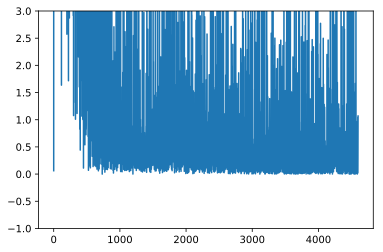

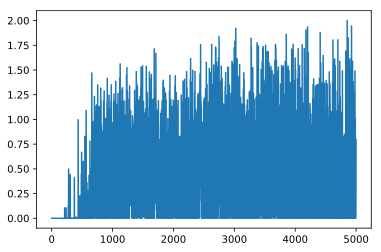

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

xx0 = list(range(len(loss_history[0])))
xx1 = list(range(len(loss_history[1])))

plt.plot(xx0, loss_history[0])
plt.ylim(-1.0,3.0)
plt.show()

plt.plot(xx1, loss_history[1])
plt.show()

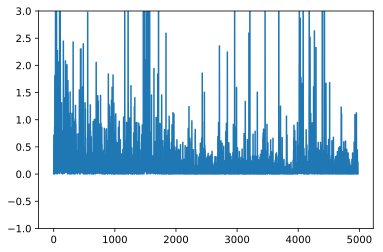

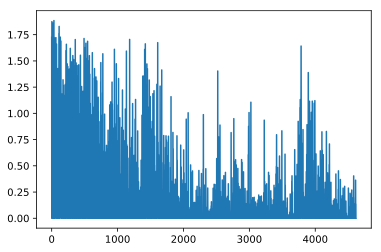

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

xx0 = list(range(len(loss_history[0])))
xx1 = list(range(len(loss_history[1])))

plt.plot(xx0, loss_history[0])
plt.ylim(-1.0,3.0)
plt.show()

plt.plot(xx1, loss_history[1])
plt.show()